---
<div align="center">

# LSDS | Machine Learning Pipeline
</div>

---
# Project Overview
---

## Background Overview
In **critical care**, being able to accurately predict how long a patient will stay in the intensive care unit is essential for managing resources effectively and improving patient outcomes. This challenge is complex because many clinical factors are involved, including vital signs, laboratory results, and the treatments administered. That is why close collaboration between clinical expertise and advanced data analytics is necessary to develop a reliable solution.

---

## Available Data
The [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) dataset, curated by the Massachusetts Institute of Technology, is one of the most comprehensive open-access databases for critical care research. It offers a wealth of de-identified data, including patient demographics, vital signs, lab results, and treatment details, which are invaluable for developing machine learning models.

---

## Approach / Methodology
We will begin by isolating the most relevant data from the MIMIC-III dataset using Google Cloud’s BigQuery service, which is well suited to handle such high volume datasets efficiently. Through extensive Exploratory Data Analysis (EDA), we aim to identify the critical features and patterns that influence patient outcomes. This initial phase will guide the selection of pertinent variables, setting the foundation for a robust predictive model.

---

## Machine Learning Pipeline
The next step is to build a complete machine learning pipeline that handles everything from preparing the data and creating features to training and validating the model. By including profiling throughout the entire process, we make sure to continuously monitor key performance measures like how long tasks take and how much computing power is used. This is especially important given the large amount of data we are working with. This approach allows us to fine-tune the machine learning algorithm we select, ultimately delivering a reliable model to predict the length of stay in the intensive care unit.

---

## Conclusions
In conclusion, by leveraging BigQuery for efficient data extraction and performing a comprehensive exploratory analysis of the MIMIC dataset, we hope to develop a robust machine learning pipeline to predict ICU length of stay. This project aims to achieve more accurate and timely predictions, ultimately supporting improved resource allocation, enhanced clinical decision-making, and better patient outcomes in critical care settings.

---

## Additional Considerations
Each stage of the pipeline, from data extraction and preprocessing through model training and validation, has been meticulously profiled to monitor execution time, percentage of code line hits, and identify any potential bottlenecks. This comprehensive profiling approach ensures our solution efficiently handles large data volumes and provides valuable insights for continuous improvement of the overall process.

---
## Project Dependencies
---

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')
from time import (time)

In [3]:
# Get the starting time before importing the modules
startTime = time()

# Import simple modules
from typing import (Tuple)
import os

# Define the path to the environment key
key = './ml-pipeline-key.json'

# Set the GOOGLE Credentials to access the dataset in the cloud
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key

# Import main modules
import numpy as np
import pandas as pd
from functools import (lru_cache)
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler)
from pyspark.ml.regression import (LinearRegression, RandomForestRegressor)
from pyspark.sql.types import (ArrayType, StringType, BooleanType)
from pyspark.ml.evaluation import (RegressionEvaluator)
from pyspark.sql import functions as F
from pyspark.sql.window import (Window)
from pyspark.sql import (SparkSession)
from pyspark.ml import (Pipeline)
from google.cloud import (storage)
from google.cloud import (bigquery, bigquery_storage)
import bigframes.pandas as bpd

# Custom Imports
from Utils import (loadConfig, loadPathsConfig, loadQueries)
from ExploratoryDataAnalysis.DatasetAnalyser import (DatasetAnalyser)
from DataPreprocessing.CustomDecorators import (profileResources)
from DataPreprocessing.BiqQueryLoader import (BigQueryLoader)

# Print the amount of time it took to import everything
print(f"Took{(time() - startTime) : .3e}(s) to import all the modules!")

Took 6.236e+00(s) to import all the modules!


In [4]:
# Load the configs
config = loadConfig()
pathsConfig = loadPathsConfig()
queries = loadQueries()

In [5]:
# # Define the path to the environment key
# key = './ml-pipeline-key.json'

# # Set the GOOGLE Credentials to access the dataset in the cloud
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key

# Define the Project from which to use the BigQuery
bpd.options.bigquery.project = "ml-pipeline-455620"

# Remove pandas column limit when inspecting a dataframe
pd.set_option('display.max_rows', None)

In [6]:
# Create a Client to query the data
client = bigquery.Client.from_service_account_json(key)
bqstorage = bigquery_storage.BigQueryReadClient.from_service_account_json(key)

---
## Exploratory Data Analysis
---

Given the MIMIC dataset, we aim to obtain greater insights on how the data is organized within the multiple tables and gain a better understanding on how we can harness the data to properly train a Machine Learning Model to help us correctly predict the Length of Stay (LOS) of a given patient that entered the Intensive Care Unit (ICU).

---
### MIMIC-III Dataset
---

The [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) Dataset contains multiple tables from which we are going to select the ones that provide a greater value to our project and further analyse them to better gain a better understanding of the available data. Furthermore, its important to notice that we have uploaded the tables from the dataset onto the google cloud BigQuery Service to help us properly manage these high volumes of data, as this dataset contains a wide range of tables covering billing, procedures, laboratory results, microbiology, clinical notes and ICU events.

Since our project focuses on predicting ICU length of stay, MIMIC provides a robust platform to explore complex clinical patterns and build predictive models that can help optimize patient care and resource allocation, we chose the tables that offer the most relevant structured information:

1. **Patient demographics and admission context**  
   **PATIENTS** with age, sex and date of birth for baseline characteristics  
   **ADMISSIONS** with admission and discharge times, insurance type, marital status, discharge location and in-hospital mortality indicator  

2. **ICU episode definitions**  
   **ICUSTAYS** with ICU entry and exit timestamps and unit transfers for ground truth length of stay  

3. **High volume clinical measurements**  
   **CHARTEVENTS** for vital signs, ventilator settings and infusion rates as dynamic predictors  

4. **Diagnosis coding**  
   **DIAGNOSES_ICD** for assigned ICD-9 codes per hospitalization  
   **D_ICD_DIAGNOSES** for human-readable code titles to enable grouping and interpretation  

5. **Measurement metadata**  
   **D_ITEMS** for item identifiers, units and categories that define every measurement captured in the ICU event tables  

For more details regarding the tables within the dataset, feel free to see the official ``MIMIC-III`` documentation [here](https://mimic.mit.edu/docs/iii/tables/chartevents/).

In addition, before diving into the selected tables, it’s worth noting that we chose not to profile any data plotting or image processing functions. While these routines can be time consuming, they don’t directly affect the core pipeline’s performance as they exist solely to provide visual insights into the data.

> Now let's proceed to analyse the selected tables!

---
#### ADMISSIONS Table
---
> The ADMISSIONS table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique HADM_ID, the ADMISSIONS table can be considered as a definition table for HADM_ID. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

| ADMISSIONS           | Description                                                                                       |
|:--------------------:|:-------------------------------------------------------------------------------------------------:|
| ADMISSION_TYPE       | Describes the nature of the admission (e.g., ELECTIVE, URGENT, NEWBORN, EMERGENCY)                |
| ADMITTIME            | Timestamp indicating when the patient was admitted to the hospital                                |
| DISCHTIME            | Timestamp indicating when the patient was discharged from the hospital                            |
| DEATHTIME            | Timestamp recording the time of in-hospital death, if applicable                                  |
| INSURANCE            | Contains the insurance provider details for the patient                                           |
| LANGUAGE             | Indicates the language spoken by the patient                                                      |
| RELIGION             | Provides the patient's religious affiliation                                                      |
| MARITAL_STATUS       | Describes the patient's marital status                                                            |
| ETHNICITY            | Specifies the patient's ethnic background                                                         |
| HOSPITAL_EXPIRE_FLAG | Binary indicator (1 or 0) showing whether the patient died during the hospital stay               |

In [9]:
def getAdmissionsV1():
    # Define the query to perform
    admissionsQuery = (
        """
        SELECT 
            ADMISSION_TYPE,
            ADMITTIME,
            DISCHTIME,
            DEATHTIME,
            INSURANCE,
            LANGUAGE,
            RELIGION,
            MARITAL_STATUS,
            ETHNICITY,
            HOSPITAL_EXPIRE_FLAG
        FROM `MIMIC.ADMISSIONS`;
        """
    )
    
    # Run the query
    queryJob = client.query(admissionsQuery)
    
    # Wait for the job to complete and get the results
    results = queryJob.result()
    
    # Convert the results to a Pandas DataFrame
    admissions = results.to_dataframe()

    # Return the final dataframe
    return admissions

# Perform profiling
%lprun -f getAdmissionsV1 admissions=getAdmissionsV1()

Timer unit: 1e-07 s

Total time: 2.50039 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3845903163.py
Function: getAdmissionsV1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getAdmissionsV1():
     2                                               # Define the query to perform
     3         1          4.0      4.0      0.0      admissionsQuery = (
     4         1          6.0      6.0      0.0          """
     5                                                   SELECT 
     6                                                       ADMISSION_TYPE,
     7                                                       ADMITTIME,
     8                                                       DISCHTIME,
     9                                                       DEATHTIME,
    10                                                       INSURANCE,
    11                                                       LANGUAG

In this first approach to query the admissions data, we began by mainly using the BigQuery Client API to fetch the raw results and then converting them to a DataFrame. However, we quickly discovered that the two‐step pattern: calling `queryJob.result()` followed by the `queryJob.to_dataframe()`, introduced a major **performance bottleneck**, since it downloads JSON over REST in a single‐threaded loop and copies the data twice. To overcome this, we:

1. Switched to the BigQuery Storage API by passing a `BigQueryReadClient` into `to_dataframe()`, which leverages parallel, Arrow‐based streaming  
2. Collapsed the RPCs into a single call (`queryJob.to_dataframe(create_bqstorage_client=bqstorage`), eliminating the extra `.result()` round-trip  

In [10]:
def getAdmissionsV2():
    # Define the query to perform
    admissionsQuery = (
        """
        SELECT 
            ADMISSION_TYPE,
            ADMITTIME,
            DISCHTIME,
            DEATHTIME,
            INSURANCE,
            LANGUAGE,
            RELIGION,
            MARITAL_STATUS,
            ETHNICITY,
            HOSPITAL_EXPIRE_FLAG
        FROM `MIMIC.ADMISSIONS`;
        """
    )
    
    # Run the query
    queryJob = client.query(admissionsQuery)
    
    # Convert the results to a Pandas DataFrame
    admissions = queryJob.to_dataframe(
        create_bqstorage_client=bqstorage
    )
    
    # Return the final dataframe
    return admissions

# Perform profiling
%lprun -f getAdmissionsV2 admissions=getAdmissionsV2()

Timer unit: 1e-07 s

Total time: 1.76143 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\155230476.py
Function: getAdmissionsV2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getAdmissionsV2():
     2                                               # Define the query to perform
     3         1          3.0      3.0      0.0      admissionsQuery = (
     4         1         10.0     10.0      0.0          """
     5                                                   SELECT 
     6                                                       ADMISSION_TYPE,
     7                                                       ADMITTIME,
     8                                                       DISCHTIME,
     9                                                       DEATHTIME,
    10                                                       INSURANCE,
    11                                                       LANGUAGE

The results show that total runtime has fallen by about 40%, a significant improvement when processing large datasets. However, building the final DataFrame still dominates the overall execution time, so to reduce that overhead we switched from calling to_dataframe directly to using to_arrow with a BigQuery storage client, then converting the resulting Arrow table into a pandas DataFrame, as this two‐step approach [has proven](https://medium.com/google-cloud/announcing-google-cloud-bigquery-version-1-17-0-1fc428512171) to be able to cut down the conversion cost.

In [2]:
.805 * 1.76
.82 * 1.63

1.3365999999999998

In [11]:
def getAdmissionsV3():
    # Define the query to perform
    admissionsQuery = (
        """
        SELECT 
            ADMISSION_TYPE,
            ADMITTIME,
            DISCHTIME,
            DEATHTIME,
            INSURANCE,
            LANGUAGE,
            RELIGION,
            MARITAL_STATUS,
            ETHNICITY,
            HOSPITAL_EXPIRE_FLAG
        FROM `MIMIC.ADMISSIONS`;
        """
    )
    
    # Run the query
    queryJob = client.query(admissionsQuery)
    
    # Convert the results to a Pandas DataFrame
    admissions = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()
    
    # Return the final dataframe
    return admissions

# Perform profiling
%lprun -f getAdmissionsV3 admissions=getAdmissionsV3()

Timer unit: 1e-07 s

Total time: 1.63083 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3869382123.py
Function: getAdmissionsV3 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getAdmissionsV3():
     2                                               # Define the query to perform
     3         1          2.0      2.0      0.0      admissionsQuery = (
     4         1          5.0      5.0      0.0          """
     5                                                   SELECT 
     6                                                       ADMISSION_TYPE,
     7                                                       ADMITTIME,
     8                                                       DISCHTIME,
     9                                                       DEATHTIME,
    10                                                       INSURANCE,
    11                                                       LANGUAG

As expected, the overall execution time fell from about 1.91 seconds to 1.61 seconds, confirming our optimisation. In particular, the DataFrame construction step dropped from roughly 1.42 seconds ($0.805 × 1.76 = 1.42$) to about 1.34 seconds ($0.82 × 1.63 = 1.34$), an improvement of around 5%. Therefore, these results show that switching to the two-step Arrow conversion meaningfully reduces conversion overhead and contributes to the observed speed-up.

To drive performance even higher, we can introduce caching using the `lru_cache` decorator from Python’s `functools` module. The first call will incur the full query cost, but every following call will return the cached result almost instantly. Let’s update our function for retrieving admissions data:

In [12]:
# Use lru_cache
@lru_cache(maxsize=None) 
def getAdmissionsV4():
    # Define the query to perform
    admissionsQuery = (
        """
        SELECT 
            ADMISSION_TYPE,
            ADMITTIME,
            DISCHTIME,
            DEATHTIME,
            INSURANCE,
            LANGUAGE,
            RELIGION,
            MARITAL_STATUS,
            ETHNICITY,
            HOSPITAL_EXPIRE_FLAG
        FROM `MIMIC.ADMISSIONS`;
        """
    )
    
    # Run the query
    queryJob = client.query(admissionsQuery)
    
    # Convert the results to a Pandas DataFrame
    admissions = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()
    
    # Return the final dataframe
    return admissions

In [13]:
# Clear function cache
getAdmissionsV4.cache_clear()

# Profile getAdmissionsV3 (First Run - Empty Cache / Cache Miss)
%lprun -f getAdmissionsV4.__wrapped__ admissions = getAdmissionsV4()

Timer unit: 1e-07 s

Total time: 1.40364 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3823502988.py
Function: getAdmissionsV4 at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @lru_cache(maxsize=None) 
     3                                           def getAdmissionsV4():
     4                                               # Define the query to perform
     5         1          2.0      2.0      0.0      admissionsQuery = (
     6         1          5.0      5.0      0.0          """
     7                                                   SELECT 
     8                                                       ADMISSION_TYPE,
     9                                                       ADMITTIME,
    10                                                       DISCHTIME,
    11                                                       DEATHTIME,
    12                                                       INSU

In [14]:
# Profile getAdmissionsV3 (Second Run - Cache Hit)
%lprun -f getAdmissionsV4.__wrapped__ admissions = getAdmissionsV4()

Timer unit: 1e-07 s

Total time: 0 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3823502988.py
Function: getAdmissionsV4 at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           @lru_cache(maxsize=None) 
     3                                           def getAdmissionsV4():
     4                                               # Define the query to perform
     5                                               admissionsQuery = (
     6                                                   """
     7                                                   SELECT 
     8                                                       ADMISSION_TYPE,
     9                                                       ADMITTIME,
    10                                                       DISCHTIME,
    11                                                       DEATHTIME,
    12                                                       INSURANCE,

As we can see, during the second execution, the query completed so quickly that the profiler reported a runtime of 0 seconds! Therefore caching can significantly boost the overall performance by avoiding repeated database queries, reducing server load and providing instant access to frequently requested data. This optimization becomes especially critical when dealing with large-scale datasets or applications that require high responsiveness.

Despite the performance gains offered by `lru_cache`, we will not use it during this initial exploratory analysis. Since each query will only be executed once, the caching mechanism would not provide any real benefit at this stage.

> From here on, we’ll apply these optimization techniques to maximize performance while taking into account the constraints of our current system.

In [15]:
# Check the first 3 rows
admissions.head(3)

,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,HOSPITAL_EXPIRE_FLAG
0,EMERGENCY,2111-01-24 11:53:00+00:00,2111-01-25 22:40:00+00:00,2111-01-25 22:40:00+00:00,Private,None,UNOBTAINABLE,SINGLE,WHITE,1
1,EMERGENCY,2150-09-05 17:49:00+00:00,2150-09-12 18:30:00+00:00,2150-09-12 18:30:00+00:00,Medicare,ENGL,CATHOLIC,WIDOWED,ASIAN - JAPANESE,1
2,EMERGENCY,2190-09-18 22:39:00+00:00,2190-09-24 20:40:00+00:00,2190-09-24 20:40:00+00:00,Medicaid,None,CATHOLIC,MARRIED,WHITE,1


In [16]:
# Checking the dtypes of each feature
admissions.dtypes

ADMISSION_TYPE                       object
ADMITTIME               datetime64[us, UTC]
DISCHTIME               datetime64[us, UTC]
DEATHTIME               datetime64[us, UTC]
INSURANCE                            object
LANGUAGE                             object
RELIGION                             object
MARITAL_STATUS                       object
ETHNICITY                            object
HOSPITAL_EXPIRE_FLAG                  int64
dtype: object

In [17]:
# Create an admissions analyser
admissionAnalyser = DatasetAnalyser(df=admissions)

In [18]:
# Plot the distribution of Ethnicity
# admissionAnalyser.plotFeatureDistribution(feature='ETHNICITY')

In [19]:
# Plot the distribution of Language
# admissionAnalyser.plotFeatureDistribution(feature='LANGUAGE') 

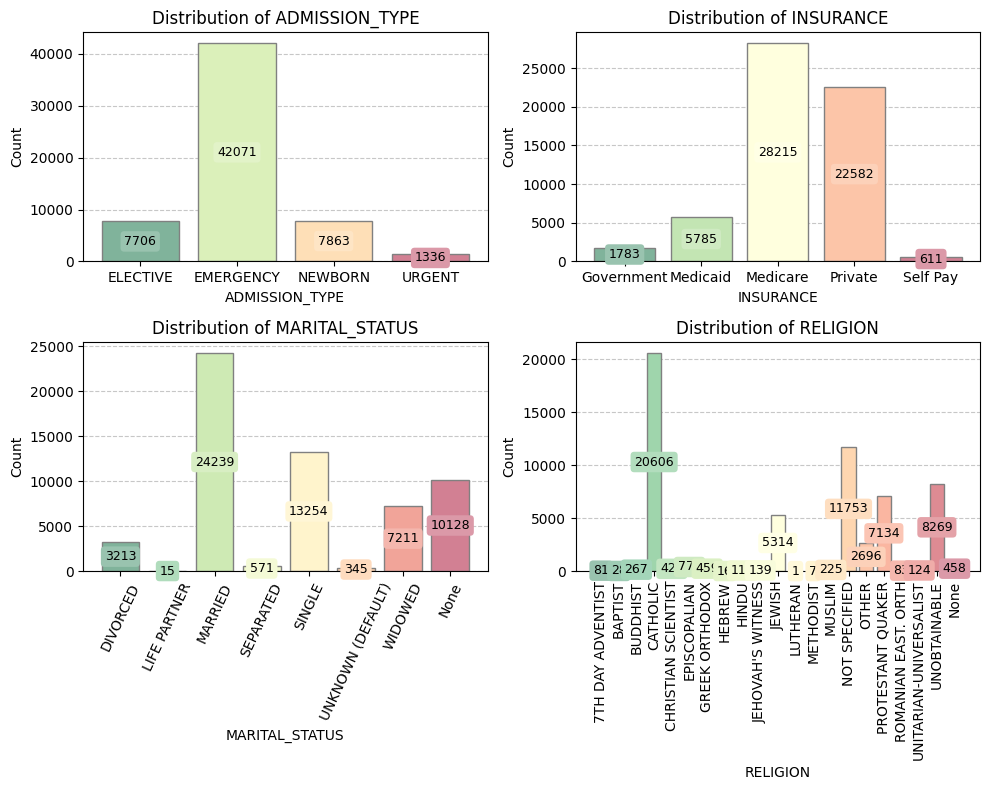

In [20]:
# Plot feature Distributions
# (Note: There is no need to plot the Distribution of any ID feature)
admissionAnalyser.plotFeatureDistributions(
    features=[
        'ADMISSION_TYPE',
        'INSURANCE',
        'MARITAL_STATUS',
        'RELIGION'
    ]
)

As the chart shows, emergency admissions dominate ICU stays with more than 42 000 cases. Elective and newborn admissions each account for around 7 800 stays, while urgent admissions total just under 1 400. 

Insurance coverage is led by Medicare and private plans, with roughly 28 000 and 22 500 admissions respectively. Medicaid and other government programs cover fewer than 6 000 and 1 800 patients and under 700 paid out of pocket. 

Most patients are married or single, comprising over 24 000 and 13 250 individuals respectively, with a substantial group either widowed or having no recorded status. 

Among religious affiliations, Catholics form the largest group at more than 20 600, followed by patients without a specified faith at about 11 750 and those in the other category at just over 7 100. Smaller faith groups include Muslim patients and a range of Protestant denominations.

---
#### DIAGNOSES_ICD Table
---

> The DIAGNOSES_ICS table contains ICD diagnoses for patients, most notably ICD-9 diagnoses.

| DIAGNOSES_ICD | Description                                                                                                                          |
|:-------------:|:------------------------------------------------------------------------------------------------------------------------------------:|
| SUBJECT_ID    | Unique identifier for each patient                                                                                                   |
| HADM_ID       | Unique identifier for each hospital admission, defining a specific patient stay                                                      |
| SEQ_NUM       | Indicates the order or priority of the ICD diagnoses for the patient, which can affect treatment reimbursement                       |
| ICD9_CODE     | Contains the ICD-9 code corresponding to the diagnosis assigned to the patient during the hospital stay                              |

In [21]:
def getDiagnoses():
    # Define the query to perform
    diagnosesICDQuery = (
        """
        SELECT 
            SUBJECT_ID,
            HADM_ID,
            SEQ_NUM,
            ICD9_CODE
        FROM `MIMIC.DIAGNOSES_ICD`;
        """
    )
    
    # Run the query
    queryJob = client.query(diagnosesICDQuery)
    
    # Convert the results to a Pandas DataFrame
    diagnoses = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the diagnoses dataframe
    return diagnoses

# Perform profiling
%lprun -f getDiagnoses diagnoses=getDiagnoses()

Timer unit: 1e-07 s

Total time: 1.87513 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3009884206.py
Function: getDiagnoses at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getDiagnoses():
     2                                               # Define the query to perform
     3         1          4.0      4.0      0.0      diagnosesICDQuery = (
     4         1          6.0      6.0      0.0          """
     5                                                   SELECT 
     6                                                       SUBJECT_ID,
     7                                                       HADM_ID,
     8                                                       SEQ_NUM,
     9                                                       ICD9_CODE
    10                                                   FROM `MIMIC.DIAGNOSES_ICD`;
    11                                                   """
    12 

As we can see, even with a different query the most time‐consuming step remains constructing the Arrow table from the retrieved data. Since downstream computations execute quickly and our focus here is on exploratory data analysis, there is no need to pursue further optimization at this stage.

Throughout this phase I will continue profiling each query to gain insight into the data, but I will not include detailed comments on those results since they will follow the same pattern. Given the current performance and our analytical objectives, additional tuning would offer minimal benefit.

In [22]:
# Check the first 3 rows
diagnoses.head(3)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109,172335,1.0,40301
1,109,172335,2.0,486
2,109,172335,3.0,58281


In [23]:
# Checking the dtypes of each feature
diagnoses.dtypes

SUBJECT_ID      int64
HADM_ID         int64
SEQ_NUM       float64
ICD9_CODE      object
dtype: object

In [24]:
# Checking the amount of different illnesses
print(f"There are in total {len(diagnoses['ICD9_CODE'].value_counts())} illnesses reported in the dataset!")

There are in total 6984 illnesses reported in the dataset!


Since the dataset has a **tremendous amount of unique illnesses**, we have decided **not to plot its distribution**.

In [25]:
# Create an diagnoses analyser
diagnosesAnalyser = DatasetAnalyser(df=diagnoses)

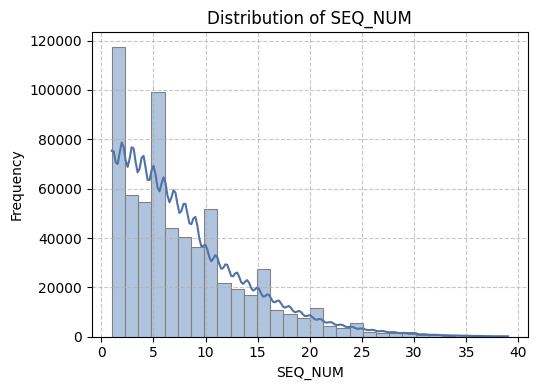

In [26]:
# Plot feature Distributions
# (Note: There is no need to plot the Distribution of any ID feature)
diagnosesAnalyser.plotFeatureDistributions(
    features=['SEQ_NUM']
)

The `SEQ_NUM` indicates the rank or priority of each diagnosis code for a patient, which in turn has a direct impact on billing and reimbursement. The distribution follows a clear right-skewed, almost exponential-decay pattern where the first position alone accounts for nearly 120 000 records, the second for about 100 000, and by the tenth position you’re already below 50 000. This shows that most patients carry fewer than ten diagnosis codes, reflecting routine or primary conditions. Beyond ten, the long, thinning tail up to almost forty codes represents a small subset of very complex cases. Moreover, the visible bumps at certain mid-range positions likely correspond to clusters of secondary diagnoses associated with specific treatments or extended ICU stays.

---
#### D_ICD_DIAGNOSES Table
---

> This table defines International Classification of Diseases Version 9 (ICD-9) codes for diagnoses. These codes are assigned at the end of the patient’s stay and are used by the hospital to bill for care provided.

| D_ICD_DIAGNOSES | Description                                                                                                      |
|:---------------:|:----------------------------------------------------------------------------------------------------------------:|
| **ROW_ID**      | Internal surrogate key for the table (simple integer row identifier)                                             |
| **ICD9_CODE**   | International Classification of Diseases, Ninth Revision (ICD-9) code uniquely identifying a diagnostic concept  |
| **SHORT_TITLE** | Concise, abbreviated title for the diagnosis code (up to 50 characters)                                          |
| **LONG_TITLE**  | Full, expanded description of the diagnosis code (up to 300 characters)                                          |


In [27]:
def getDicdDiagnoses():
    # Define the query to perform
    dIcdDiagnosesQuery = (
        """
        SELECT 
            ICD9_CODE,
            SHORT_TITLE,
            LONG_TITLE
        FROM `MIMIC.D_ICD_DIAGNOSES`;
        """
    )
    
    # Run the query
    queryJob = client.query(dIcdDiagnosesQuery)
    
    # Convert the results to a Pandas DataFrame
    dIcdDiagnoses = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the d_items dataframe
    return dIcdDiagnoses

# Perform profiling
%lprun -f getDicdDiagnoses dIcdDiagnoses=getDicdDiagnoses()

Timer unit: 1e-07 s

Total time: 1.41924 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\1105646397.py
Function: getDicdDiagnoses at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getDicdDiagnoses():
     2                                               # Define the query to perform
     3         1          3.0      3.0      0.0      dIcdDiagnosesQuery = (
     4         1          6.0      6.0      0.0          """
     5                                                   SELECT 
     6                                                       ICD9_CODE,
     7                                                       SHORT_TITLE,
     8                                                       LONG_TITLE
     9                                                   FROM `MIMIC.D_ICD_DIAGNOSES`;
    10                                                   """
    11                                               )
    12 

In [28]:
# Showcase the first 5 rows
dIcdDiagnoses.head()

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,4957,"""ventilation"" pneumonit","""Ventilation"" pneumonitis"
1,94416,1 deg burn back of hand,Erythema [first degree] of back of hand
2,94414,1 deg burn fingr w thumb,Erythema [first degree] of two or more digits ...
3,36911,1 eye-sev/oth-blind NOS,Better eye: severe vision impairment; lesser e...
4,94811,10-19% bdy brn/10-19% 3d,Burn [any degree] involving 10-19 percent of b...


This table (`D_ICD_DIAGNOSES`) only provides the standardized disease classifications, listing each diagnosis by its ICD code along with a brief textual description.

---
#### D_ITEMS Table
---

> The D_ITEMS table defines ITEMID, which represents measurements in the database. Measurements of the same type (e.g. heart rate) will have the same ITEMID (e.g. 211). The ITEMID column is an alternate primary key to this table: it is unique to each row.

| D_ITEMS          | Description                                                                                                                                                                        |
|:----------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| **ROW_ID**       | Internal surrogate key for the table (simple integer row identifier)                                                                                                               |
| **ITEMID**       | Alternate primary key; uniquely identifies each measurement concept (e.g. heart rate has CareVue 211 and MetaVision 220045)                                                        |
| **LABEL**        | Full name of the concept represented by this ITEMID (e.g. “Heart Rate”)                                                                                                            |
| **ABBREVIATION** | Shorthand or code for the label (only populated for MetaVision entries, e.g. “HR”)                                                                                                 |
| **DBSOURCE**     | Origin ICU system: either `carevue` or `metavision`, indicating which underlying database the ITEMID came from                                                                     |
| **LINKSTO**      | Name of the event table containing this ITEMID (e.g. `chartevents`, `inputevents_cv`, etc.). If `NULL`, the data isn’t yet available but may be planned for future releases        |
| **CATEGORY**     | High-level grouping of the concept (e.g. “ABG” for arterial blood gas, “IV Medication” for intravenous drugs)                                                                      |
| **UNITNAME**     | Unit of measurement (e.g. “bpm”, “mmHg”); may be blank if the unit varies, is not applicable, or was not recorded consistently                                                     |
| **PARAM_TYPE**   | Data type recorded: one of `num`, `char`, `datetime`, etc., indicating whether the value is numeric, free text, or a timestamp                                                     |
| **CONCEPTID**    | (Reserved) Higher-level concept identifier for grouping similar ITEMIDs—present in the schema but not currently used in the public MIMIC-III release                               |


In [29]:
def getDItems():
    # Define the query to perform
    dItemsQuery = (
        """
        SELECT 
            LABEL,
            ABBREVIATION,
            CATEGORY
        FROM `MIMIC.D_ITEMS`
        WHERE LABEL IS NOT NULL 
            AND CATEGORY IS NOT NULL 
            AND ABBREVIATION IS NOT NULL;
        """
    )
    
    # Run the query
    queryJob = client.query(dItemsQuery)
    
    # Convert the results to a Pandas DataFrame
    dItems = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the d_items dataframe
    return dItems

# Perform profiling
%lprun -f getDItems dItems=getDItems()

Timer unit: 1e-07 s

Total time: 1.57817 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\164894233.py
Function: getDItems at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getDItems():
     2                                               # Define the query to perform
     3         1          4.0      4.0      0.0      dItemsQuery = (
     4         1          5.0      5.0      0.0          """
     5                                                   SELECT 
     6                                                       LABEL,
     7                                                       ABBREVIATION,
     8                                                       CATEGORY
     9                                                   FROM `MIMIC.D_ITEMS`
    10                                                   WHERE LABEL IS NOT NULL 
    11                                                       AND CATEGORY IS 

In [30]:
# Showcase the first 5 rows
dItems.head()

,LABEL,ABBREVIATION,CATEGORY
0,Ensure,Ensure,Fluids - Other (Not In Use)
1,Ensure Plus,Ensure Plus,Fluids - Other (Not In Use)
2,"Dextrose 2,5%","Dextrose 2,5%",Fluids - Other (Not In Use)
3,Potassium Chloride,Potassium Chloride - KCL,Medications
4,Hydrochloric Acid - HCL,Hydrochloric Acid - HCL,Medications


The `D_ITEMS` table lists each measurement along with its label, abbreviation, category and additional metadata, making it directly applicable to every record in the `CHARTEVENTS` table.

---
#### ICUSTAYS Table
---

> The ICUSTAYS defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay.

| ICUSTAYS          | Description                                                                                                                             |
|:-----------------:|:---------------------------------------------------------------------------------------------------------------------------------------:|
| SUBJECT_ID        | Unique identifier for each patient.                                                                                                     |
| HADM_ID           | Unique identifier for each hospital admission, defining a specific patient stay.                                                        |
| ICUSTAY_ID        | Unique identifier for each ICU stay, representing a single ICU encounter.                                                               |
| DBSOURCE          | Indicates the original ICU database source (e.g., 'carevue' for 2001–2008 or 'metavision' for 2008–2012), which affects data archiving. |
| FIRST_CAREUNIT    | The first ICU type where the patient was cared for during the ICU stay.                                                                 |
| LAST_CAREUNIT     | The last ICU type where the patient was cared for, noting that transfers between ICU types can occur within a single stay.              |
| FIRST_WARDID      | Identifier for the first ICU unit (ward) where the patient was admitted, as recorded in the hospital database.                          |
| LAST_WARDID       | Identifier for the last ICU unit (ward) where the patient stayed during their ICU encounter.                                            |
| INTIME            | Timestamp indicating when the patient was transferred into the ICU.                                                                     |
| OUTTIME           | Timestamp indicating when the patient was transferred out of the ICU.                                                                   |
| LOS               | Length of stay for the ICU encounter, measured in fractional days, which may encompass multiple ICU units.                              |

In [31]:
def getStaysICU():
    # Define the query to perform
    staysICUQuery = (
        """
        SELECT 
            SUBJECT_ID,
            HADM_ID,
            ICUSTAY_ID,
            DBSOURCE,
            FIRST_CAREUNIT,
            LAST_CAREUNIT,
            FIRST_WARDID,
            LAST_WARDID,
            INTIME,
            OUTTIME,
            LOS
        FROM `MIMIC.ICUSTAYS`;
        """
    )
    
    # Run the query
    queryJob = client.query(staysICUQuery)
    
    # Convert the results to a Pandas DataFrame
    icuStays = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the icu stays dataframe
    return icuStays

# Perform profiling
%lprun -f getStaysICU icuStays=getStaysICU()

Timer unit: 1e-07 s

Total time: 1.79727 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\2526497768.py
Function: getStaysICU at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getStaysICU():
     2                                               # Define the query to perform
     3         1          3.0      3.0      0.0      staysICUQuery = (
     4         1          8.0      8.0      0.0          """
     5                                                   SELECT 
     6                                                       SUBJECT_ID,
     7                                                       HADM_ID,
     8                                                       ICUSTAY_ID,
     9                                                       DBSOURCE,
    10                                                       FIRST_CAREUNIT,
    11                                                       LAST_CAREUNIT,
   

In [32]:
# Check the first 3 rows
icuStays.head(3)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023


In [33]:
# Checking the dtypes of each feature
icuStays.dtypes

SUBJECT_ID                      int64
HADM_ID                         int64
ICUSTAY_ID                      int64
DBSOURCE                       object
FIRST_CAREUNIT                 object
LAST_CAREUNIT                  object
FIRST_WARDID                    int64
LAST_WARDID                     int64
INTIME            datetime64[us, UTC]
OUTTIME           datetime64[us, UTC]
LOS                           float64
dtype: object

In [34]:
# Create an diagnoses analyser
icuStaysAnalyser = DatasetAnalyser(df=icuStays)

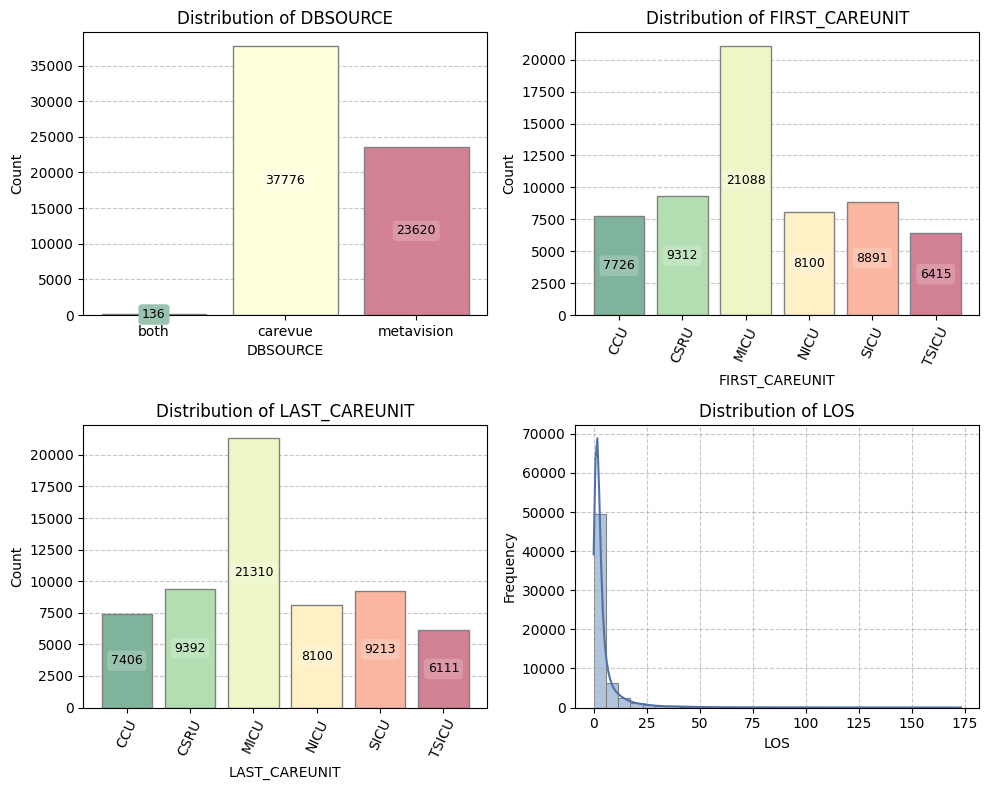

In [35]:
# Plot feature Distributions 
# (Note: There is no need to plot the Distribution of any ID feature)
icuStaysAnalyser.plotFeatureDistributions(
    features=[
        'DBSOURCE',
        'FIRST_CAREUNIT',
        'LAST_CAREUNIT',
        'LOS'
    ]
)

When examining the ICU stays data, it becomes apparent that the CareVue system captures the majority of encounters (approximately 38 000 records), while MetaVision accounts for around 24 000, with only a small overlap between the two sources. 

Additionally, the Medical ICU (MICU) manages the highest volume of admissions at roughly 21 000, followed by the Cardiac Surgery Recovery Unit and the Surgical ICU, each contributing just under 9 000 stays. The Coronary Care Unit and the Trauma Surgical ICU register comparatively fewer admissions.

The distribution of length of stay is skewed to the right as most patients require one to two days of intensive monitoring and more than half are discharged by day three. By day ten, only a few thousand stays remain. Moreover, a long tapering tail extends to nearly six months, reflecting a small group of complex admissions that last for extended periods. This pattern highlights the need to manage a high volume of short term stays while also reserving capacity for the relatively rare but resource intensive long term cases and ensuring balanced bed use, staffing and equipment allocation.

---
#### PATIENTS Table
---

> The PATIENTS table defines each SUBJECT_ID in the database, i.e. defines a single patient.

| PATIENTS     | Description                                                                                                                                          |
|:------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------:|
| SUBJECT_ID   | Unique identifier for each patient, used to link patient data across tables.                                                                         |
| GENDER       | The genotypical sex of the patient.                                                                                                                  |
| DOB          | Date of birth of the patient. For patients older than 89, DOB is shifted (set to 300 years before the first admission) for HIPAA compliance.         |
| DOD          | Date of death for the patient, merging information from hospital (DOD_HOSP) and social security (DOD_SSN) records, with DOD_HOSP taking priority.    |
| DOD_HOSP     | Date of death as recorded in the hospital database.                                                                                                  |
| DOD_SSN      | Date of death from the social security database.                                                                                                     |
| EXPIRE_FLAG  | Binary flag indicating whether the patient died (i.e., whether DOD is not null).                                                                     |

In [36]:
def getPatients():
    # Define the query to perform
    patientsQuery = (
        """
        SELECT 
            SUBJECT_ID,
            GENDER,
            DOB,
            DOD,
            DOD_HOSP,
            DOD_SSN,
            EXPIRE_FLAG
        FROM `MIMIC.PATIENTS`;
        """
    )
    
    # Run the query
    queryJob = client.query(patientsQuery)
    
    # Convert the results to a Pandas DataFrame
    patients = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the patients dataframe
    return patients

# Perform profiling
%lprun -f getPatients patients=getPatients()

Timer unit: 1e-07 s

Total time: 1.41402 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\1810398181.py
Function: getPatients at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getPatients():
     2                                               # Define the query to perform
     3         1          4.0      4.0      0.0      patientsQuery = (
     4         1         13.0     13.0      0.0          """
     5                                                   SELECT 
     6                                                       SUBJECT_ID,
     7                                                       GENDER,
     8                                                       DOB,
     9                                                       DOD,
    10                                                       DOD_HOSP,
    11                                                       DOD_SSN,
    12                      

In [37]:
# Check the first 3 rows
patients.head(3)

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,249,F,2075-03-13 00:00:00+00:00,NaT,NaT,NaT,0
1,253,F,2089-11-26 00:00:00+00:00,NaT,NaT,NaT,0
2,258,F,2124-09-19 00:00:00+00:00,NaT,NaT,NaT,0


In [38]:
# Checking the dtypes of each feature
patients.dtypes

SUBJECT_ID                   int64
GENDER                      object
DOB            datetime64[us, UTC]
DOD            datetime64[us, UTC]
DOD_HOSP       datetime64[us, UTC]
DOD_SSN        datetime64[us, UTC]
EXPIRE_FLAG                  int64
dtype: object

In [39]:
# Create an patients analyser
patientsAnalyser = DatasetAnalyser(df=patients)

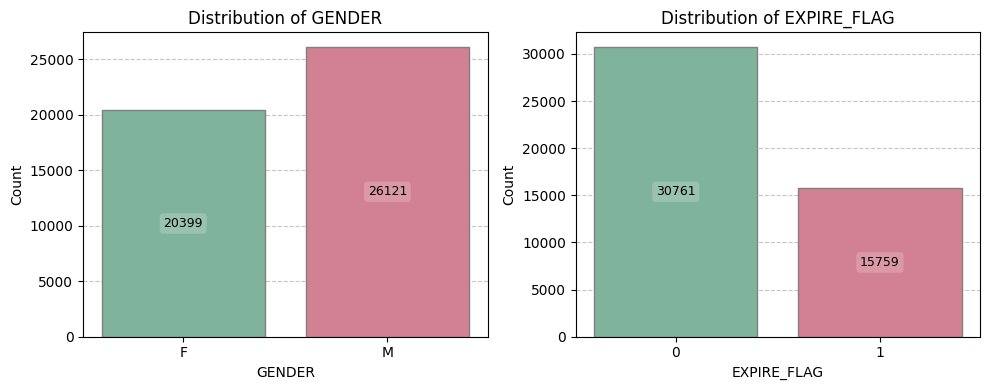

In [40]:
# Plot feature Distributions 
# (Note: There is no need to plot the Distribution of any ID feature)
patientsAnalyser.plotFeatureDistributions(
    features=[
        'GENDER',
        'EXPIRE_FLAG'
    ],
    forceCategorical=True
)

Analysis of the Patients table shows a modest male predominance: roughly 26 121 men versus 20 399 women were admitted to the ICU. Moreover, in-hospital survival is high, with about 30 761 patients discharged alive compared to 15 759 who did not survive, corresponding to a survival rate of approximately 66%, reflecting generally effective critical-care outcomes.

---
#### CHARTEVENTS Table
---
> CHARTEVENTS contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The electronic chart displays patients' routine vital signs and any additional information relevant to their care: ventilator settings, laboratory values, code status, mental status, and so on. As a result, the bulk of information about a patient’s stay is contained in CHARTEVENTS. Furthermore, even though laboratory values are captured elsewhere (LABEVENTS), they are frequently repeated within CHARTEVENTS. This occurs because it is desirable to display the laboratory values on the patient’s electronic chart, and so the values are copied from the database storing laboratory values to the database storing the CHARTEVENTS.

| CHARTEVENTS   | Description                                                                                                      |
|:-------------:|:----------------------------------------------------------------------------------------------------------------:|
| ROW_ID        | Unique row identifier for each record in the table                                                               |
| SUBJECT_ID    | Unique identifier for each patient                                                                               |
| HADM_ID       | Unique identifier for each hospital admission                                                                    |
| ICUSTAY_ID    | Unique identifier for each ICU stay                                                                              |
| ITEMID        | Identifier for a single measurement type (e.g., heart rate) corresponding to a specific recorded measurement     |
| CHARTTIME     | Timestamp when the observation was made, serving as a proxy for the actual measurement time.                     |
| STORETIME     | Timestamp when the observation was manually input or validated by clinical staff                                 |
| CGID          | Identifier for the caregiver who validated the measurement                                                       |
| VALUE         | Recorded value of the measurement; may be textual or numeric, with numeric data also stored in VALUENUM          |
| VALUENUM      | Numeric representation of the measurement value when applicable, otherwise null                                  |
| VALUEUOM      | Unit of measurement for the recorded value, if appropriate                                                       |
| WARNING       | Metavision-specific flag indicating if a warning was raised during measurement                                   |
| ERROR         | Metavision-specific flag indicating if an error occurred during the measurement process                          |
| RESULTSTATUS  | CareVue-specific field indicating the type of measurement, such as 'Manual' or 'Automatic'                       |
| STOPPED       | CareVue-specific field indicating whether the measurement was stopped                                            |

> Given that the CHARTEVENTS table alone occupies roughly 30 GB in our Cloud Storage bucket, we chose to retrieve only the first 50 000 rows to keep the dataset manageable. Consequently, our current review of its contents remains exploratory and conceptual rather than comprehensive.

In [41]:
def getChartevents():
    # Define the query to perform
    charteventsQuery = (
        """
        SELECT
          SUBJECT_ID,
          HADM_ID,
          ICUSTAY_ID,
          ITEMID,
          CHARTTIME,
          VALUE,
          VALUENUM,
          VALUEUOM
        FROM `MIMIC.CHARTEVENTS`
        LIMIT 50000;
        """
    )
    
    # Run the query
    queryJob = client.query(charteventsQuery)
    
    # Convert the results to a Pandas DataFrame
    chartevents = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the patients dataframe
    return chartevents

# Perform profiling
%lprun -f getChartevents chartevents=getChartevents()

Timer unit: 1e-07 s

Total time: 1.27721 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\1055832544.py
Function: getChartevents at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getChartevents():
     2                                               # Define the query to perform
     3         1          3.0      3.0      0.0      charteventsQuery = (
     4         1          6.0      6.0      0.0          """
     5                                                   SELECT
     6                                                     SUBJECT_ID,
     7                                                     HADM_ID,
     8                                                     ICUSTAY_ID,
     9                                                     ITEMID,
    10                                                     CHARTTIME,
    11                                                     VALUE,
    12                

In [42]:
# Showcase the first 5 rows
chartevents.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM
0,17245,196101,225398.0,1,2101-06-08 19:00:00+00:00,0.33,NaN,None
1,17515,100635,291921.0,1,2102-11-07 17:00:00+00:00,0.25,NaN,None
2,17515,100635,291921.0,1,2102-11-07 19:00:00+00:00,0.33,NaN,None
3,17515,100635,291921.0,1,2102-11-07 23:10:00+00:00,0.33,NaN,None
4,17515,100635,291921.0,1,2102-11-08 09:00:00+00:00,NaN,NaN,None


The CHARTEVENTS table captures every recorded measurement and intervention during each ICU stay. It links patient and admission identifiers with the specific item used, the exact timestamp of the observation, and both the raw and numeric values recorded. This comprehensive log lets us trace every vital sign, lab result, infusion rate or other bedside event throughout a patient’s critical-care journey.

---
<div align="center">

## Additional Analysis
</div>

---

We barely scrapped the surface with the previous analysis, so let's try to achieve greater insights with the data! By leveraging the data from the available tables, let's try to derive new information from them!

---
### Illnesses Analysis
---
#### The most Common Ilnesses
---

In [43]:
def getMostCommonIllnesses():
    # Fetch the query developed
    mostCommonIllnessesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Most-Common-Illnesses']
    
    # Run the query
    queryJob = client.query(mostCommonIllnessesQuery)
    
    # Convert the results to a Pandas DataFrame
    mostCommonIllnesses = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return mostCommonIllnesses

# Perform profiling
%lprun -f getMostCommonIllnesses mostCommonIllnesses=getMostCommonIllnesses()

Timer unit: 1e-07 s

Total time: 1.21501 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\2229316724.py
Function: getMostCommonIllnesses at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getMostCommonIllnesses():
     2                                               # Fetch the query developed
     3         1         19.0     19.0      0.0      mostCommonIllnessesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Most-Common-Illnesses']
     4                                               
     5                                               # Run the query
     6         1    3843477.0    4e+06     31.6      queryJob = client.query(mostCommonIllnessesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3    8283692.0    3e+06     68.2      mostCommonIllnesses = quer

In [44]:
# Showcase the most common illnesses on the ICU
mostCommonIllnesses.head()

,ILLNESS,TOTAL_CASES
0,Hypertension NOS,20703
1,CHF NOS,13111
2,Atrial fibrillation,12891
3,Crnry athrscl natve vssl,12429
4,Acute kidney failure NOS,9119


The most common illnesses among ICU patients are mainly related to heart and kidney problems. Hypertension is the most frequent, with over 20 700 cases, followed by heart failure and atrial fibrillation with around 13 100 and 12 900 cases. Coronary artery disease and acute kidney failure also appear often, with about 12 400 and 9 100 cases.

> These results show that cardiovascular and kidney conditions are key drivers of ICU admissions.

---
#### Most Frequent Co-Occurring Diagnoses
---

In [45]:
def getFrequentCoOcurringDiagnoses():
    # Fetch the query developed
    mostFrequentCoOccurringDiagnosesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Most-Frequent-Co-Occuring-Diagnoses']
    
    # Run the query
    queryJob = client.query(mostFrequentCoOccurringDiagnosesQuery)
    
    # Convert the results to a Pandas DataFrame
    mostFrequentCoOccurringDiagnoses = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return mostFrequentCoOccurringDiagnoses

# Perform profiling
%lprun -f getFrequentCoOcurringDiagnoses mostFrequentCoOccurringDiagnoses=getFrequentCoOcurringDiagnoses()

Timer unit: 1e-07 s

Total time: 2.08244 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\1551923560.py
Function: getFrequentCoOcurringDiagnoses at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getFrequentCoOcurringDiagnoses():
     2                                               # Fetch the query developed
     3         1         27.0     27.0      0.0      mostFrequentCoOccurringDiagnosesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Most-Frequent-Co-Occuring-Diagnoses']
     4                                               
     5                                               # Run the query
     6         1    2334263.0    2e+06     11.2      queryJob = client.query(mostFrequentCoOccurringDiagnosesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3   1765

In [46]:
# Showcase the most most frequent co-occuring illnesses
mostFrequentCoOccurringDiagnoses.head()

,ILLNESS_A,ILLNESS_B,TOTAL_CO_OCCURENCIES
0,Hypertension NOS,Crnry athrscl natve vssl,6844
1,Hypertension NOS,Atrial fibrillation,5790
2,Atrial fibrillation,CHF NOS,5745
3,Hyperlipidemia NEC/NOS,Hypertension NOS,5227
4,DMII wo cmp nt st uncntr,Hypertension NOS,5051


The most frequent co-occurring diagnoses show a strong pattern of cardiovascular and metabolic conditions appearing together in ICU patients. The most common pair is hypertension and coronary artery disease, with over 6 800 co-occurrences, reflecting how these conditions often develop together. Hypertension and atrial fibrillation follow closely with around 5 800 cases, while atrial fibrillation and heart failure co-occur in nearly 5 750 patients, highlighting the clinical link between rhythm disorders and cardiac dysfunction. Hypertension also frequently appears alongside hyperlipidemia and type 2 diabetes without complications, each pairing showing more than 5 000 co-occurrences. These results suggest that many ICU patients present with clusters of chronic conditions, especially involving the heart and metabolic system, which likely contribute to disease severity and complexity of care.

---
#### High Length of Stay Deseases
---

As any Hospital is interested on their patients, it can be quite fulcral to have a deep understanding of the deseases that most likely lead to a higher length of stay in Intensive Unit Care in order to raise a higher awareness to all the medical professionals towards the extra need of medical supplies, technicians and equipment to better maitain and serve the Hospital when someone enters the ICU with such deseases.

In [47]:
def getHighLengthOfStayDeseases():
    # Fetch the query developed
    illnessLOSQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['High-Length-Of-Stay-Illnesses']
    
    # Run the query
    queryJob = client.query(illnessLOSQuery)
    
    # Convert the results to a Pandas DataFrame
    illnessLOS = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return illnessLOS

# Perform profiling
%lprun -f getHighLengthOfStayDeseases illnessLOS=getHighLengthOfStayDeseases()

Timer unit: 1e-07 s

Total time: 1.2604 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3981775854.py
Function: getHighLengthOfStayDeseases at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getHighLengthOfStayDeseases():
     2                                               # Fetch the query developed
     3         1         25.0     25.0      0.0      illnessLOSQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['High-Length-Of-Stay-Illnesses']
     4                                               
     5                                               # Run the query
     6         1    2557186.0    3e+06     20.3      queryJob = client.query(illnessLOSQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3   10037322.0    3e+06     79.6      illnessLOS = queryJob.to_ar

In [48]:
# Showcase the illnesses that, in average lead to a longer length of stay on the ICU
illnessLOS.head()

,illness,TOTAL_CASES,AVG_LOS_DAYS,MEDIAN_LOS_DAYS
0,Retrolental fibroplasia,173,83.38,82.45
1,Perinatal chr resp dis,185,79.75,80.76
2,25-26 comp wks gestation,107,76.86,87.49
3,Extreme immatur 500-749g,113,75.90,80.91
4,Extreme immatur 750-999g,139,69.38,74.60


The longest ICU stays are driven by severe prematurity and its complications. Retrolental fibroplasia averages 83 days in the unit (median 82), perinatal chronic respiratory disease averages 80 days (median 81), and infants born at 500 to 749 grams or 750 to 999 grams stay an average of 76 days and 69 days respectively, with similarly high medians. These figures include only diagnoses with at least fifty cases, so they reliably highlight where extended critical care and specialised neonatal staffing are most needed.

---
#### The Deadliest Illnesses
---

In [49]:
def getDeadliestIllnesses():
    # Fetch the query developed
    deadliestIllnessesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Deadliest-Illnesses']
    
    # Run the query
    queryJob = client.query(deadliestIllnessesQuery)
    
    # Convert the results to a Pandas DataFrame
    deadliestIllnesses = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return deadliestIllnesses

# Perform profiling
%lprun -f getDeadliestIllnesses deadliestIllnesses=getDeadliestIllnesses()

Timer unit: 1e-07 s

Total time: 1.13134 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\2933173999.py
Function: getDeadliestIllnesses at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getDeadliestIllnesses():
     2                                               # Fetch the query developed
     3         1         27.0     27.0      0.0      deadliestIllnessesQuery = queries['Exploratory-Data-Analysis']['Illnesses-Analysis']['Deadliest-Illnesses']
     4                                               
     5                                               # Run the query
     6         1    2615616.0    3e+06     23.1      queryJob = client.query(deadliestIllnessesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3    8682792.0    3e+06     76.7      deadliestIllnesses = queryJob.to

In [50]:
# Showcase the top 10 deadliest illnesses
deadliestIllnesses.head()

,ILLNESS,TOTAL_DEATHS
0,Hypertension NOS,8333
1,CHF NOS,8020
2,Atrial fibrillation,7290
3,Acute kidney failure NOS,5432
4,Crnry athrscl natve vssl,5004


The illnesses that account for the most deaths in the ICU are mainly heart and kidney conditions. Hypertension not otherwise specified leads with 8333 deaths. Congestive heart failure not otherwise specified follows with 8020 deaths and atrial fibrillation with 7290 deaths. Acute kidney failure not otherwise specified is responsible for 5432 deaths and coronary atherosclerosis of native vessels for 5004 deaths. These figures reflect both the high frequency and severity of chronic cardiovascular and renal diseases in critically ill patients.

---
### Mortality Rates
---
Let's explore how mortality rates differ among patient groups, namely:
- Gender
- Marital Status
- Ethnicity
- Care Units


---
#### Gender
---

Let's begin with `gender`!

In [51]:
def getGenderMortalityRates():
    # Fetch the query developed
    genderMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Gender']
    
    # Run the query
    queryJob = client.query(genderMortalityRatesQuery)
    
    # Convert the results to a Pandas DataFrame
    genderMortalityRates = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return genderMortalityRates

# Perform profiling
%lprun -f getGenderMortalityRates genderMortalityRates=getGenderMortalityRates()

Timer unit: 1e-07 s

Total time: 1.33436 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\2507341722.py
Function: getGenderMortalityRates at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getGenderMortalityRates():
     2                                               # Fetch the query developed
     3         1         20.0     20.0      0.0      genderMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Gender']
     4                                               
     5                                               # Run the query
     6         1    2459176.0    2e+06     18.4      queryJob = client.query(genderMortalityRatesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3   10873913.0    4e+06     81.5      genderMortalityRates = queryJob.to_arrow

In [52]:
# Showcase the mortality ratio between male and female patients
genderMortalityRates.head()

,GENDER,TOTAL_DEATHS,TOTAL_PATIENTS,GENDER_MORTALITY_RATIO,PROPORTIONAL_MORTALITY_RATIO
0,M,8524,26121,0.326327,0.540897
1,F,7235,20399,0.354674,0.459103


In [53]:
# Create a amaliser to visualize the results
datasetAnalyserGender = DatasetAnalyser(df=genderMortalityRates)

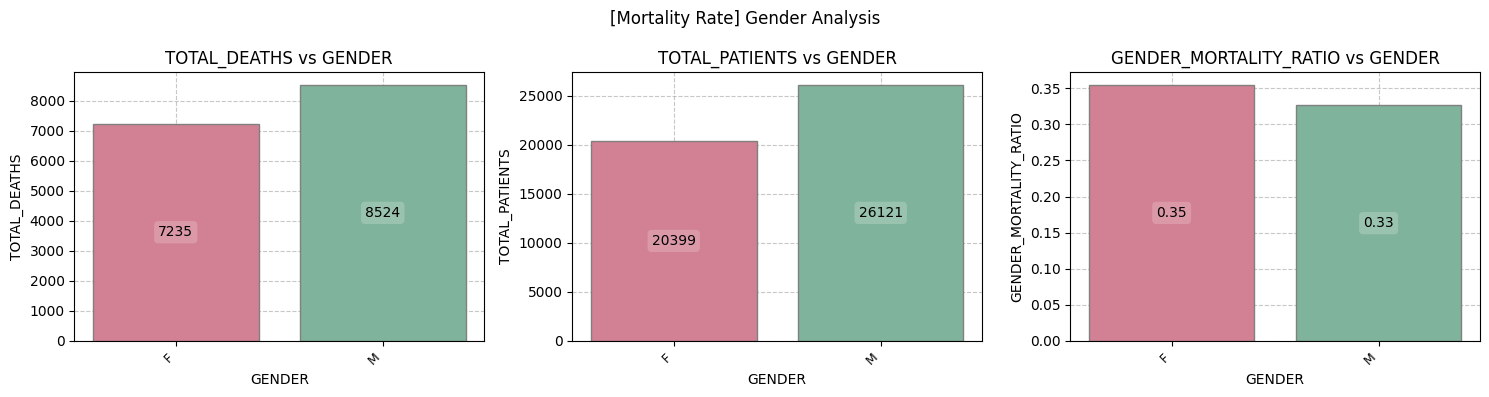

In [54]:
# Plot the data within a bar plot
datasetAnalyserGender.plotXyCharts(x='GENDER', y=['TOTAL_DEATHS', 'TOTAL_PATIENTS', 'GENDER_MORTALITY_RATIO'], title='[Mortality Rate] Gender Analysis')

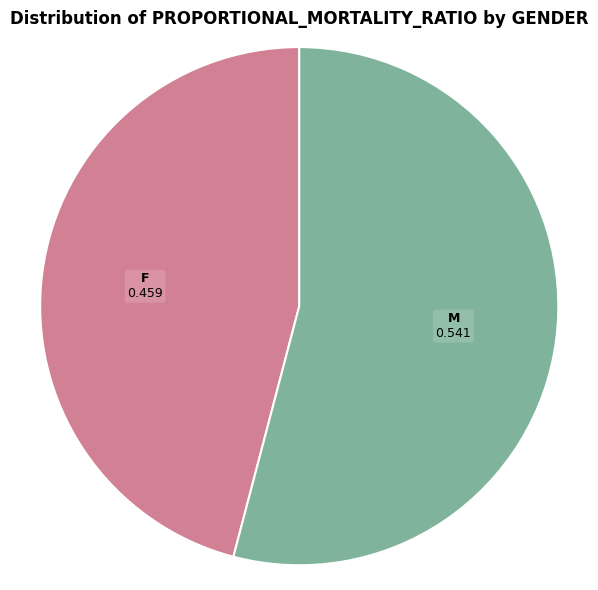

In [55]:
# Plot a PieChart
datasetAnalyserGender.plotPieChart(numericColumn='PROPORTIONAL_MORTALITY_RATIO', labelColumn='GENDER')

Male patients account for more deaths in absolute terms (8 524 versus 7 235 for female patients) but they also make up a larger share of the ICU population. About 33% of men did not survive their stay compared with 35% of women, which means that the risk of in-hospital death is slightly higher for female patients. 

In total, 54% of all deaths occurred among men and 46% among women. These results highlight the importance of examining outcomes by gender to uncover and address any disparities in critical care.

---
#### Marital Status
---
Moving onto `Marital Status`.

In [56]:
def getMaritalStatusMortalityRates():
    # Fetch the query developed
    maritalStatusMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Marital-Status']
    
    # Run the query
    queryJob = client.query(maritalStatusMortalityRatesQuery)
    
    # Convert the results to a Pandas DataFrame
    maritalStatusMortalityRates = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return maritalStatusMortalityRates

# Perform profiling
%lprun -f getMaritalStatusMortalityRates maritalStatusMortalityRates=getMaritalStatusMortalityRates()

Timer unit: 1e-07 s

Total time: 1.26545 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\4201675622.py
Function: getMaritalStatusMortalityRates at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getMaritalStatusMortalityRates():
     2                                               # Fetch the query developed
     3         1         19.0     19.0      0.0      maritalStatusMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Marital-Status']
     4                                               
     5                                               # Run the query
     6         1    2504050.0    3e+06     19.8      queryJob = client.query(maritalStatusMortalityRatesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3   10140451.0    3e+06     80.1      mari

In [57]:
# Showcase the mortality ratio within all the patient's marital status
maritalStatusMortalityRates

,MARITAL_STATUS,TOTAL_DEATHS,TOTAL_PATIENTS,MARITAL_STATUS_MORTALITY_RATE,PROPORTIONAL_MORTALITY_RATIO
0,MARRIED,7125,18589,0.383291,0.452123
1,WIDOWED,3249,5489,0.591911,0.206168
2,SINGLE,2988,9828,0.304029,0.189606
3,DIVORCED,969,2377,0.407657,0.061489
4,UNKNOWN (DEFAULT),170,313,0.543131,0.010787
5,SEPARATED,140,396,0.353535,0.008884
6,LIFE PARTNER,2,15,0.133333,0.000127


In [58]:
# Create a analyser to visualize the results
datasetAnalyserMaritalStatus = DatasetAnalyser(df=maritalStatusMortalityRates)

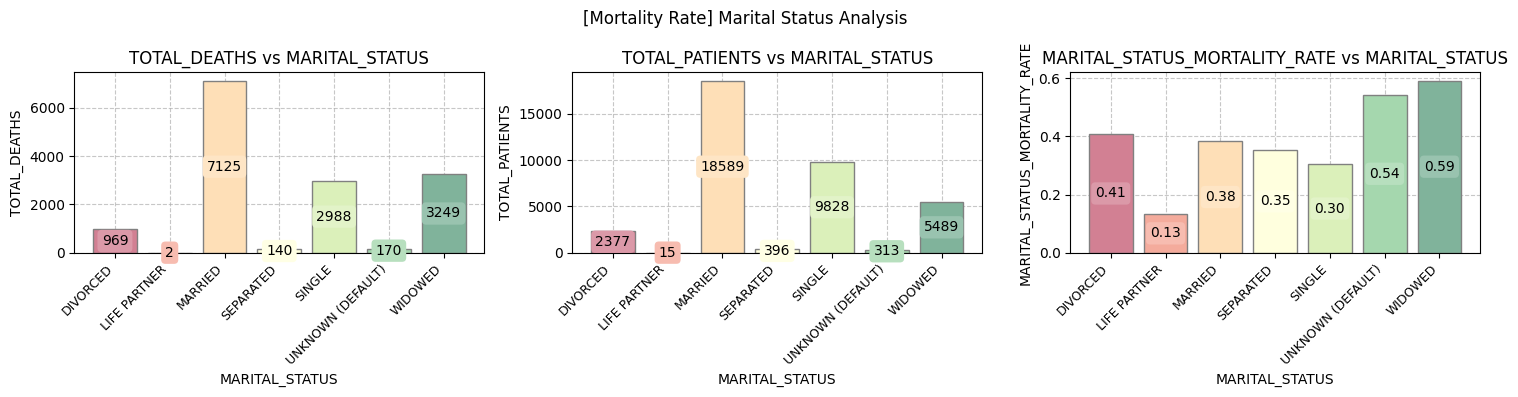

In [59]:
# Plot the data within a bar plot
datasetAnalyserMaritalStatus.plotXyCharts(x='MARITAL_STATUS', y=['TOTAL_DEATHS', 'TOTAL_PATIENTS', 'MARITAL_STATUS_MORTALITY_RATE'], title='[Mortality Rate] Marital Status Analysis')

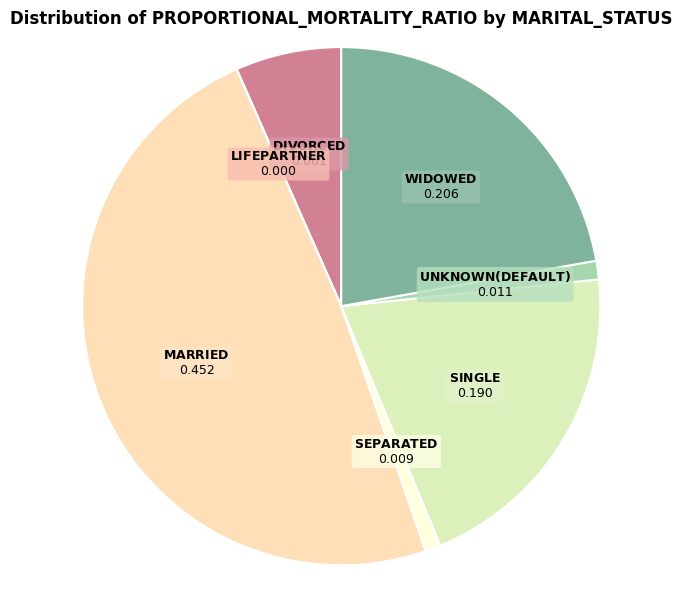

In [60]:
# Plot a PieChart
datasetAnalyserMaritalStatus.plotPieChart(numericColumn='PROPORTIONAL_MORTALITY_RATIO', labelColumn='MARITAL_STATUS')

Firstly, widowed patients have the highest in‐class mortality, with 59% of them dying during their ICU stay. Additionally patients with unknown marital status follow at fifty four percent, and divorced patients at 41%. Moreover, married patients experience a thirty 8% mortality rate, separated patients 35%, and single patients 30%. Those recorded as life partners have the lowest mortality at 13%, although this group is very small. 

In terms of share of all ICU deaths, married patients account for 45%, widowed for 21%, single for 19%, divorced for 6%, unknown status for 1%, separated for < 1%, and life partners for virtually none.

---
#### Ethnicity
---

In [61]:
def getEthnicityMortalityRates():
    # Fetch the query developed
    ethnicityMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Ethnicity']
    
    # Run the query
    queryJob = client.query(ethnicityMortalityRatesQuery)
    
    # Convert the results to a Pandas DataFrame
    ethnicityMortalityRates = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return ethnicityMortalityRates

# Perform profiling
%lprun -f getEthnicityMortalityRates ethnicityMortalityRates=getEthnicityMortalityRates()

Timer unit: 1e-07 s

Total time: 1.22535 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3191866757.py
Function: getEthnicityMortalityRates at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getEthnicityMortalityRates():
     2                                               # Fetch the query developed
     3         1         19.0     19.0      0.0      ethnicityMortalityRatesQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Ethnicity']
     4                                               
     5                                               # Run the query
     6         1    2483628.0    2e+06     20.3      queryJob = client.query(ethnicityMortalityRatesQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3    9758023.0    3e+06     79.6      ethnicityMortalityRates =

In [62]:
# Showcase the mortality ratio within all the patient's ethnicities
ethnicityMortalityRates

,ETHNICITY_GROUP,TOTAL_DEATHS,TOTAL_PATIENTS,ETHNICITY_MORTALITY_RATE,PROPORTIONAL_MORTALITY_RATIO
0,Unknown/Not Provided,2314,5530,0.418445,0.146837
1,White/European,11448,32433,0.352974,0.726442
2,Pacific Islander,5,15,0.333333,0.000317
3,Black/African American,1099,3875,0.283613,0.069738
4,Native American,11,47,0.234043,0.000698
5,Other,311,1511,0.205824,0.019735
6,Hispanic/Latino,321,1652,0.194310,0.020369
7,Asian,326,1691,0.192785,0.020687


In [63]:
# Create a amaliser to visualize the results
datasetAnalyserEthnicity = DatasetAnalyser(df=ethnicityMortalityRates)

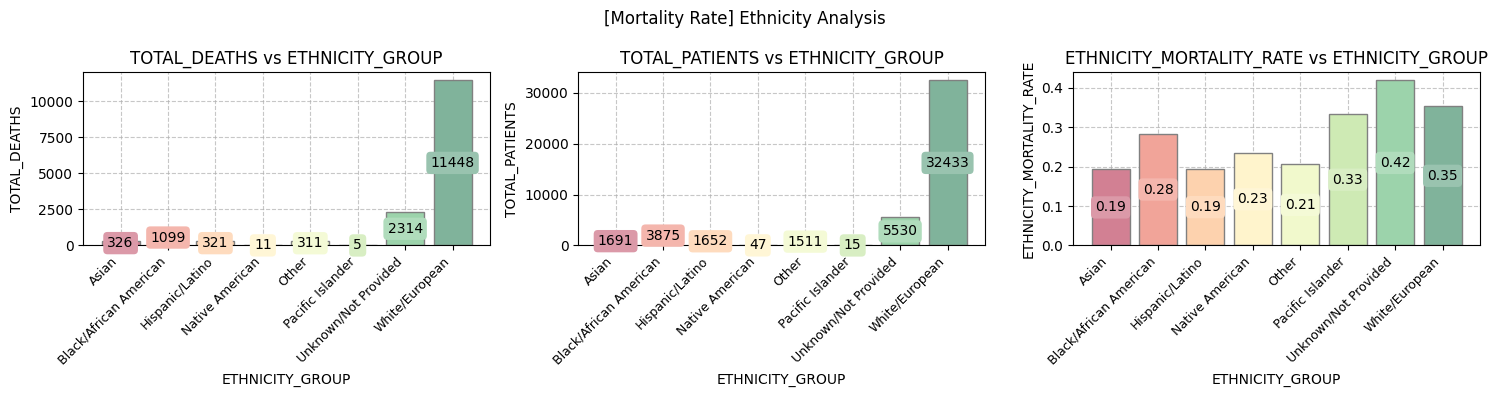

In [64]:
# Plot the data within a bar plot
datasetAnalyserEthnicity.plotXyCharts(x='ETHNICITY_GROUP', y=['TOTAL_DEATHS', 'TOTAL_PATIENTS', 'ETHNICITY_MORTALITY_RATE'], title='[Mortality Rate] Ethnicity Analysis')

The data reveals clear differences in survival outcomes across ethnic groups:
- White European patients make up the vast majority of cases and of deaths, with a mortality rate of about 35%.
- Patients without a recorded ethnicity face the highest in‐group mortality at 42%.
- Pacific Islander patients also show a high mortality ratio at 33%, although they represent a very small sample.
- Black African American patients have a mortality rate of 28%, while Native American patients sit at 23%. Both Hispanic Latino and Asian groups experience lower mortality rates around 19%.

These patterns suggest that patients whose ethnicity is unknown or from certain minority groups may carry a higher risk of in‐hospital death. At the same time, the large share of White European patients means they account for over 70% of all deaths, so targeted quality‐of‐care initiatives should consider both individual risk and overall impact.

---
#### Care Units
---

We now will analyse how the initial care units can impact the outcome of the patient (if he lives or dies) and its length of stay in 

In [65]:
def getIcuMortalityRates():
    # Fetch the query developed
    icuMortalityQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Care-Units']
    
    # Run the query
    queryJob = client.query(icuMortalityQuery)
    
    # Convert the results to a Pandas DataFrame
    icuMortality = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return icuMortality

# Perform profiling
%lprun -f getIcuMortalityRates icuMortality=getIcuMortalityRates()

Timer unit: 1e-07 s

Total time: 1.25687 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\220915063.py
Function: getIcuMortalityRates at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getIcuMortalityRates():
     2                                               # Fetch the query developed
     3         1         20.0     20.0      0.0      icuMortalityQuery = queries['Exploratory-Data-Analysis']['Mortality-Rates']['Care-Units']
     4                                               
     5                                               # Run the query
     6         1    2434418.0    2e+06     19.4      queryJob = client.query(icuMortalityQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3   10122127.0    3e+06     80.5      icuMortality = queryJob.to_arrow(
    10         1         

In [66]:
# Showcase how each initial care unit can impact the treatment of the patient
icuMortality.head()

,FIRST_CAREUNIT,TOTAL_DEATHS,TOTAL_PATIENTS,CARE_UNIT_MORTALITY_RATE,PROPORTIONAL_MORTALITY_RATIO
0,MICU,11433,21088,0.542157,0.725490
1,CCU,3856,7726,0.499094,0.244686
2,SICU,3984,8891,0.448094,0.252808
3,TSICU,2246,6415,0.350117,0.142522
4,CSRU,2605,9312,0.279747,0.165302


In [67]:
# Create a amaliser to visualize the results
datasetAnalyserICU = DatasetAnalyser(df=icuMortality)

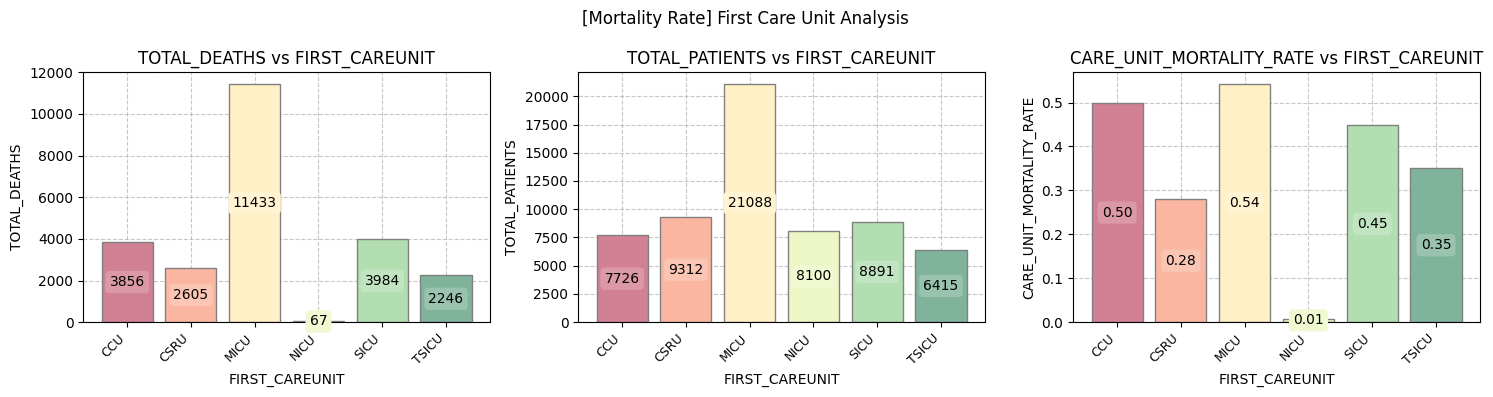

In [68]:
# Plot the data within a bar plot
datasetAnalyserICU.plotXyCharts(x='FIRST_CAREUNIT', y=['TOTAL_DEATHS', 'TOTAL_PATIENTS', 'CARE_UNIT_MORTALITY_RATE'], title='[Mortality Rate] First Care Unit Analysis')

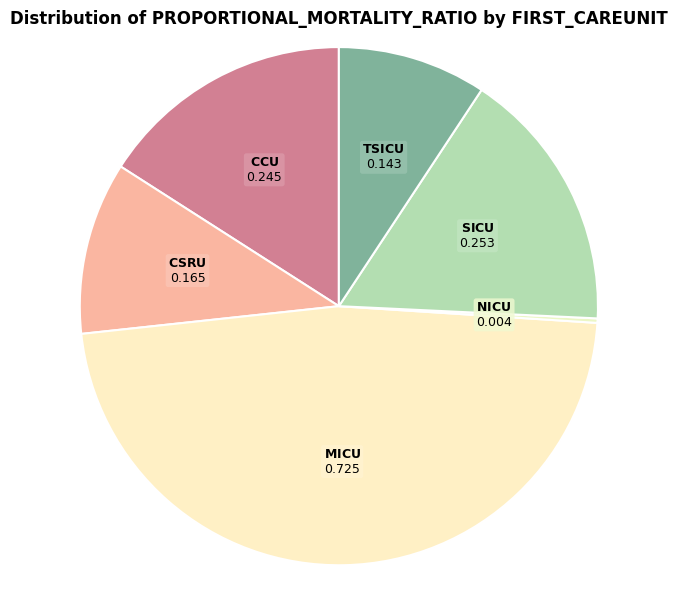

In [69]:
# Plot a PieChart
datasetAnalyserICU.plotPieChart(numericColumn='PROPORTIONAL_MORTALITY_RATIO', labelColumn='FIRST_CAREUNIT')

Regarding the First Care Unit, we can infer that:

- **Medical ICU (MICU)**: 11 433 deaths among 21 088 patients (mortality rate 54.2%).
- **Coronary Care Unit (CCU)**: 3 856 deaths among 7 726 patients (mortality rate 49.9%).
- **Surgical ICU (SICU)**: 3 984 deaths among 8 891 patients (mortality rate 44.8%).
- **Trauma Surgical ICU (TSICU)**: 2 246 deaths among 6 415 patients (mortality rate 35.0%).
- **Cardiac Surgery Recovery Unit (CSRU)**: 2 605 deaths among 9 312 patients (mortality rate 27.9%).
- **Neonatal ICU (NICU)**: 67 deaths among 8 100 patients (mortality rate 0.8%).

The Medical ICU accounts for nearly half of all ICU deaths, while the Neonatal ICU contributes less than 1%. This wide range of mortality rates highlights the differing risk profiles across care units and can help guide targeted staffing, equipment allocation and clinical protocols.

---
### Length of Stay
---

In this new subsection, let's explore how the LOS can differ depending on multiple factors of risk.

---
#### Demographic Correlations
---

Initially we are going to explore the correlations between age, gender, or ethnicity and LOS, potentially revealing disparities in outcomes

In [70]:
def getLOSDemographicCorrelations():
    # Fetch the query developed
    demographicCorrelationsQuery = queries['Exploratory-Data-Analysis']['Length-Of-Stay-Analysis']['Demographic-Correlations']
    
    # Run the query
    queryJob = client.query(demographicCorrelationsQuery)
    
    # Convert the results to a Pandas DataFrame
    demographiCorrelations = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return demographiCorrelations

# Perform profiling
%lprun -f getLOSDemographicCorrelations demographiCorrelations=getLOSDemographicCorrelations()

Timer unit: 1e-07 s

Total time: 1.18275 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\3509578284.py
Function: getLOSDemographicCorrelations at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getLOSDemographicCorrelations():
     2                                               # Fetch the query developed
     3         1         21.0     21.0      0.0      demographicCorrelationsQuery = queries['Exploratory-Data-Analysis']['Length-Of-Stay-Analysis']['Demographic-Correlations']
     4                                               
     5                                               # Run the query
     6         1    2219508.0    2e+06     18.8      queryJob = client.query(demographicCorrelationsQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3    9597482.0    3e+06     81.1  

In [71]:
# Showcase the demographic Correlations
demographiCorrelations.head()

,GENDER,ETHNICITY_GROUP,AGE_GROUP,AVG_LOS,ADMISSION_COUNT
0,F,Native American,<30,22.181818,11
1,F,Native American,51-70,19.666667,6
2,M,Native American,>70,19.000000,1
3,M,Pacific Islander,<30,15.666667,3
4,F,Unknown/Not Provided,<30,13.317259,394


In [72]:
# Create a amaliser to visualize the results
datasetAnalyserDemographicCorrelations = DatasetAnalyser(df=demographiCorrelations)

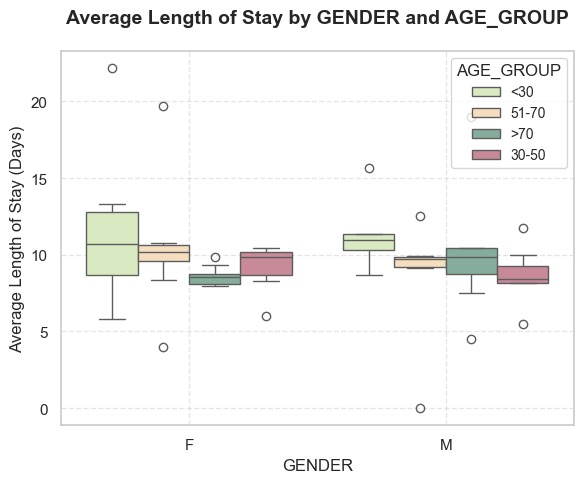

In [73]:
# Lets analyse the Average Length of Stay by the Gender and Age Group
datasetAnalyserDemographicCorrelations.plotBoxPlot(x='GENDER', y='AVG_LOS', hue='AGE_GROUP', makeSmallPlot=True)

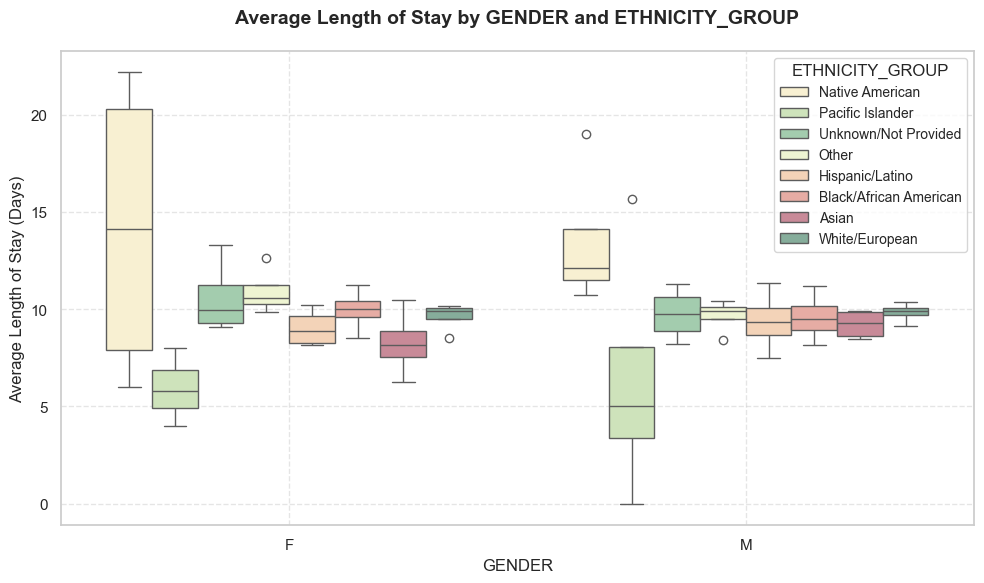

In [74]:
# Lets analyse the Average Length of Stay by Gender and Ethnicity
datasetAnalyserDemographicCorrelations.plotBoxPlot(x='GENDER', y='AVG_LOS', hue='ETHNICITY_GROUP', makeSmallPlot=False)

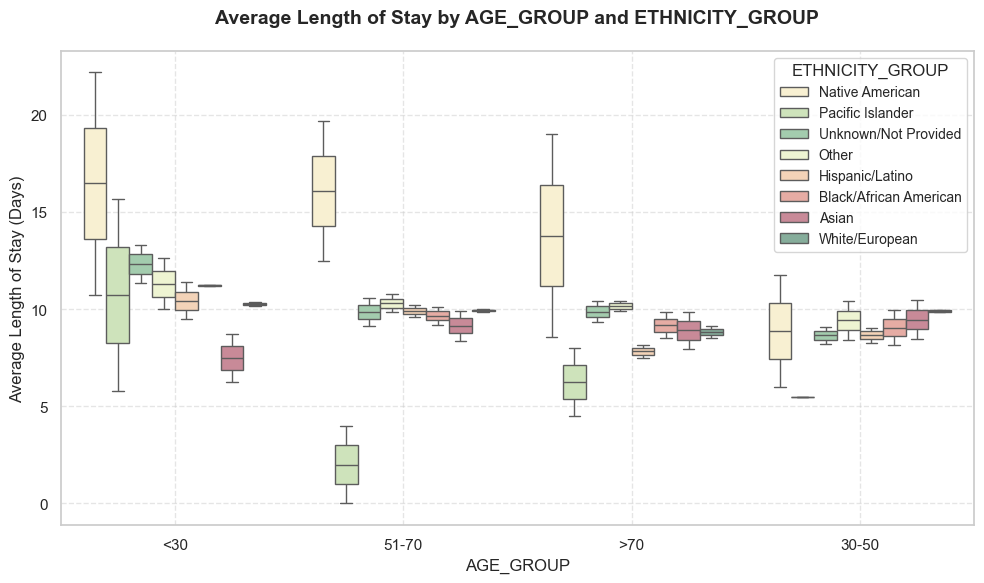

In [75]:
# Lets analyse the Average Length of Stay by the Age Group and Ethnicity Group
datasetAnalyserDemographicCorrelations.plotBoxPlot(x='AGE_GROUP', y='AVG_LOS', hue='ETHNICITY_GROUP', makeSmallPlot=False)

Overall, demographic factors appear to have only a modest effect on average ICU length of stay. Medians for most groups hover between 9 and 11 days, regardless of gender or ethnicity. The greatest variability occurs in the youngest age bracket (under 30), where neonatal cases drive a wide range (from under five days in some small-count groups) up to over 15 days for Native American patients. 

In the middle age brackets (30 to 50 and 51 to 70), length of stay converges tightly for all ethnicities and both genders at around 10 days. Patients > 70 show similar medians but with longer tails, reflecting a few extended stays among individual groups. White European, Black African American, Hispanic Latino and Asian patients all cluster around the 10-day mark across all age bands, while smaller groups such as Pacific Islanders and Native Americans exhibit more spread driven by low admission counts. These patterns suggest that, beyond the outliers in very young or very old patients or underrepresented ethnicities, most ICU stays last about 10 days on average.

---
#### Outlier Analysis
---

In [76]:
def getLOSOutliers():
    # Fetch the query developed
    outliersLOSQuery = queries['Exploratory-Data-Analysis']['Length-Of-Stay-Analysis']['Outlier-Analysis']
    
    # Run the query
    queryJob = client.query(outliersLOSQuery)
    
    # Convert the results to a Pandas DataFrame
    outliersLOS = queryJob.to_arrow(
        bqstorage_client=bqstorage
    ).to_pandas()

    # Return the final dataframe
    return outliersLOS

# Perform profiling
%lprun -f getLOSOutliers outliersLOS=getLOSOutliers()

Timer unit: 1e-07 s

Total time: 1.11301 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_2204\354383719.py
Function: getLOSOutliers at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def getLOSOutliers():
     2                                               # Fetch the query developed
     3         1         23.0     23.0      0.0      outliersLOSQuery = queries['Exploratory-Data-Analysis']['Length-Of-Stay-Analysis']['Outlier-Analysis']
     4                                               
     5                                               # Run the query
     6         1    2443190.0    2e+06     22.0      queryJob = client.query(outliersLOSQuery)
     7                                               
     8                                               # Convert the results to a Pandas DataFrame
     9         3    8659946.0    3e+06     77.8      outliersLOS = queryJob.to_arrow(
    10         1          

In [77]:
# Inspect the first 3 rows of the data retrieved
outliersLOS.head(3)

,LOS,OUTLIER_FLAG
0,102,High Outlier
1,36,High Outlier
2,35,High Outlier


In [78]:
# Check the amount of outliers
outliersLOS['OUTLIER_FLAG'].value_counts()

OUTLIER_FLAG
Normal          54219
High Outlier     4757
Name: count, dtype: int64

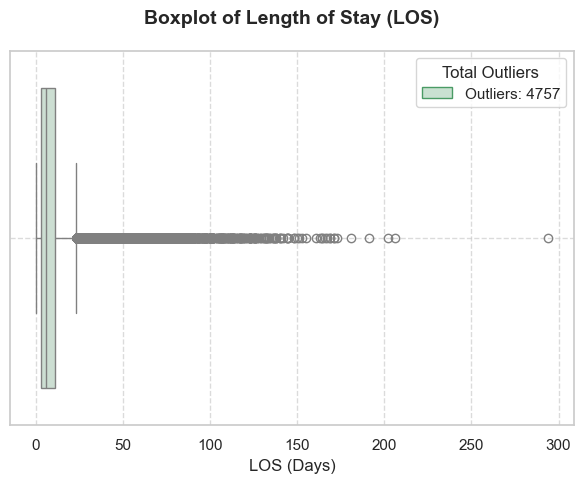

In [79]:
# Create a instance of a Dataset Analyser with the retrieved data
dataAnalyserOutliersLOS = DatasetAnalyser(df=outliersLOS)

# Plot the target outliers
dataAnalyserOutliersLOS.plotTargetOutliers()

This outlier boxplot shows that although most ICU stays are clustered within a narrow range, a small number of admissions extend far beyond. There are 4 757 stays outside the usual “whiskers”, ranging from about 30 days up to almost 300 days. These outliers make up under 10% of all stays but can heavily skew any analysis that relies on the mean or assumes a symmetric distribution.

---
<div align="center">

## Data Preprocessing
</div>

---

Given the previous extended exploratory data analysis, we are bound to manipulate the dataset's tables in order to obtain a more robust and precise dataframe with whoose help alongside some data preparation will allow us to properly train a machine learning model to correctly predict the Length of Stay of patients in the Intensive Care Unit.

---
### Data Extraction
---

Our first objective is to pull the most relevant variables from the MIMIC III database and shape them for modelling. Building on our previous exploratory work across the available tables, we carried out focused extraction, cleaning, merging, and feature-engineering steps to create a single dataset as it will serve as the input for every model that predicts a patient’s length of stay.

We began by pulling all chart-events that describe cardiovascular status, body temperature, respiratory activity, blood pressure, oxygenation, and white-blood-cell indices. These raw items were consolidated into a single dataframe and mapped to six high-level categories: heart, temperature, respiration, blood pressure, oxygen, and white blood cells. 

> This grouping allows us to keep the key physiologic measurements that will later feed the model predicting ICU length of stay.

An added challenge in this step was the inherent inconsistency in how similar variables are recorded across the database. For instance, heart rate is logged under ITEMID 211 in the CareVue system and under ITEMID 220045 in Metavision, even though they represent the same clinical concept. Additionally, some charted items suffer from inconsistent naming conventions—often abbreviated or misspelled—making direct comparison across sources unreliable. To address this, we aggregated semantically equivalent items into our high-level categories, allowing us to abstract away system-specific identifiers and preserve physiological meaning.

> This aggregation step not only simplifies our feature space but also improves robustness when integrating data from patients recorded under different documentation systems.

In [80]:
# Define the most important measurements to extract
vitalMeasurementsPatternsMap = {
    "HeartRate":           "Heart Rate",
    "O2Sat":               "SpO2",
    "RespRateSpontaneous": "Respiratory Rate (Spontaneous)",
    "RespRate":            "Respiratory Rate",
    "DiaBP":              ["Arterial Blood Pressure diastolic", "Non Invasive Blood Pressure diastolic"],
    "SysBP":              ["Arterial Blood Pressure systolic", "Non Invasive Blood Pressure systolic"],
    "Temp":               ["Temp Rectal", "Blood Temperature CCO (C)", "Temperature C"],
    "WhiteBloodCell":     ["%White Blood Cell%", "%wbc%"]
}

In [81]:
# Fetch and relabel the vital measurements from the selected tags
%lprun -f BigQueryLoader.__init__ bqLoader = BigQueryLoader(vitalMeasurementsPatternsMap)

Timer unit: 1e-07 s

Total time: 2.9e-06 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: __init__ at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                               def __init__(self, vital_patterns: dict[str, list[str] | str], dataset: str = "MIMIC"):
    13                                                   """
    14                                                   # Description:
    15                                                       -> Constructor of the MIMICDataLoader class, which initializes patterns used
    16                                                          to match items in the MIMIC D_ITEMS table, and sets a default dataset name.
    17                                                   ----------------------------------------------------------------------------------
    18                              

In [82]:
# Perform profilling on the matched_vitals_df @property method (By calling it, the code inside the method is ran)
%lprun -f bqLoader.__class__.matched_vitals_df.fget bqLoader.matched_vitals_df

Timer unit: 1e-07 s

Total time: 7.10305 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: matched_vitals_df at line 239

Line #      Hits         Time  Per Hit   % Time  Line Contents
   239                                               @property
   240                                               def matched_vitals_df(self) -> pd.DataFrame:
   241                                                   """
   242                                                   # Description:
   243                                                       -> Creates a DataFrame of item IDs and labels in D_ITEMS that match the
   244                                                          user-defined patterns (SQL LIKE clauses). Then assigns a user-friendly
   245                                                          'VITAL_NAME' to each item.
   246                                                   --------

In [83]:
# Showcase the results
bqLoader.matched_vitals_df.head()

,ITEMID,LABEL,VITAL_NAME
0,1127,"WBC (4-11,000)",WhiteBloodCell
1,226779,WbcApacheIIScore,WhiteBloodCell
2,220546,WBC,WhiteBloodCell
3,676,Temperature C,Temp
4,226329,Blood Temperature CCO (C),Temp


> Profiling indicates that both the initializer and the matched_vitals_df property execute efficiently. The only significant delay occurs during data retrieval and conversion from BigQuery to pandas — specifically in the ```bpd.read_gbq(query).to_pandas()``` step, which represents the main performance bottleneck.

Moving on, for every ICU stay, we summarised each selected vital sign over the first 24 hours by calculating its mean, minimum, maximum, standard deviation and measurement count. These early summary statistics capture the patient’s initial physiological profile, which strongly influences diagnostic decisions, treatment speed and quality, and ultimately the length of stay.

Initially, we implemented this summarization using BigQuery’s BigFrames API, which offers a pandas-like interface for working with large-scale data. While conceptually convenient, the performance was suboptimal. After more than an hour of processing, the job was still incomplete—not due to inefficient computation, but because BigFrames downloads extensive metadata after each operation, significantly slowing down execution time.

To resolve this, we restructured the entire logic into a single SQL query that computes all relevant statistics in one pass directly on the database. This change dramatically improved performance, reducing the runtime to around four seconds.

In [84]:
# Get the measured vitals of the first 24h
%lprun -f bqLoader.pivot_vitals_24h vitals_summary = bqLoader.pivot_vitals_24h()

Timer unit: 1e-07 s

Total time: 3.54645 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: pivot_vitals_24h at line 306

Line #      Hits         Time  Per Hit   % Time  Line Contents
   306                                               def pivot_vitals_24h(self) -> bpd.DataFrame:
   307                                                   """
   308                                                   # Description:
   309                                                       -> Aggregates vital measurements from CHARTEVENTS in the first 24 hours of
   310                                                          an ICU stay. Each vital is pivoted with stats like mean, min, max, std, count.
   311                                                   ----------------------------------------------------------------------------------
   312                                                   # Params:
  

> Our profiling shows that the conversion step from BigQuery into a pandas DataFrame remains the primary performance limiter. Because this process depends on transferring data from the cloud, it offers little room for further optimization.

In [85]:
# Showcase the first 5 records
vitals_summary.head()

,ICUSTAY_ID,WhiteBloodCell_mean,Temp_mean,RespRate_mean,DiaBP_mean,RespRateSpontaneous_mean,HeartRate_mean,O2Sat_mean,SysBP_mean,WhiteBloodCell_min,...,O2Sat_std,SysBP_std,WhiteBloodCell_count,Temp_count,RespRate_count,DiaBP_count,RespRateSpontaneous_count,HeartRate_count,O2Sat_count,SysBP_count
0,253885,6.3,<NA>,18.333333,<NA>,<NA>,62.055556,96.733333,<NA>,6.3,...,2.313521,<NA>,3,0,18,0,0,18,15,0
1,279055,8.6,<NA>,20.266667,<NA>,<NA>,77.866667,95.0,<NA>,8.6,...,0.912871,<NA>,3,0,15,0,0,15,13,0
2,212581,13.2,37.154286,17.825,<NA>,<NA>,85.410256,97.694444,<NA>,11.5,...,1.618102,<NA>,12,35,40,0,0,39,36,0
3,275685,8.6,<NA>,17.72,68.782609,8.0,78.48,<NA>,123.347826,8.6,...,<NA>,19.689888,1,0,25,23,7,25,0,23
4,266823,<NA>,<NA>,<NA>,<NA>,<NA>,134.25,<NA>,<NA>,<NA>,...,<NA>,<NA>,0,0,0,0,0,4,0,0


Using each patient’s date of birth, we calculated age records and excluded the ones with ages above 120, which are almost certainly data errors. We also consolidated high-cardinality categorical fields (for example, collapsing the many ethnicity labels into a few broader groups) to keep the dataset concise and interpretable. The result is a clean demographics dataframe that captures the basic ICU information for every patient.

In [86]:
# Compute the demographics dataframe
%lprun -f bqLoader.load_demoV1 icu_demo = bqLoader.load_demoV1()

Timer unit: 1e-07 s

Total time: 46.8585 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: load_demoV1 at line 69

Line #      Hits         Time  Per Hit   % Time  Line Contents
    69                                               def load_demoV1(self) -> bpd.DataFrame:
    70                                                   """
    71                                                   # Description:
    72                                                       -> Loads key tables (ICUSTAYS, ADMISSIONS, PATIENTS) from BigQuery,
    73                                                          merges them, computes AGE and LOS_HOURS, and filters out unrealistic ages.
    74                                                   ----------------------------------------------------------------------------------
    75                                                   # Params:
    76                  

From the initial version of the `load_demoV1` method, we can see that most of the time is spent on ethnicity relabeling because it relies on `np.select` to evaluate multiple conditions, triggering repeated scans and creating large intermediate arrays. 

To optimise this process, we consolidated null handling and uppercase conversion into one pass, used regex alternation to match related patterns such as “HISPANIC” or “LATINO” in a single operation, computed boolean masks once for reuse, and replaced the repeated calls to `np.select` with targeted `df.loc` assignments along with a default assignment.

In [87]:
# Compute the demographics dataframe
%lprun -f bqLoader.load_demoV2 icu_demo = bqLoader.load_demoV2()

Timer unit: 1e-07 s

Total time: 3.25396 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: load_demoV2 at line 150

Line #      Hits         Time  Per Hit   % Time  Line Contents
   150                                               def load_demoV2(self) -> bpd.DataFrame:
   151                                                   """ 
   152                                                   Loads ICUSTAYS, ADMISSIONS and PATIENTS from BigQuery,
   153                                                   merges them, computes AGE, filters unrealistic ages,
   154                                                   and assigns ETHNICITY_GROUP in a minimal number of passes.
   155                                                   """
   156                                                   # # Read & merge
   157                                                   # icu        = bpd.read_gbq(f"{self.dat

[TODO]

These optimizations reduced the ethnicity-grouping step from nearly fifty seconds to effectively zero, since the work now runs entirely in the cloud via the `bpd.read_gbq_query(query)` call. Overall `load_demo` time fell from around 47 seconds to just over 3 seconds, making the pipeline dramatically faster even on very large tables. At this point the only remaining bottleneck is the initial data pull from BigQuery through BigFrames. Further gains would demand deep changes to BigFrames itself for only marginal improvements, so we have chosen to stop here.

In [88]:
# Showcase the first 5 records
icu_demo.head()

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,GENDER,AGE,LOS,ETHNICITY
0,228557,192420,44206,M,61,0.2317,White/European
1,238322,145252,68175,M,54,6.0597,White/European
2,201619,189112,17133,F,61,2.7089,Black/African American
3,243955,161694,8543,F,65,3.5554,White/European
4,219875,134371,16788,F,70,5.7366,White/European


We also extracted a binary indicator for mechanical ventilation during the first 24 hours of ICU admission. Because needing ventilatory support signals greater illness severity and is often associated with longer stays, this “on_vent” flag will help our final model to account for that important clinical factor.

In [89]:
# Extracting the on ventilation flag for each ICU Stay
%lprun -f bqLoader.extract_ventilation_flag on_vent = bqLoader.extract_ventilation_flag()

Timer unit: 1e-07 s

Total time: 3.24649 s
File: C:\Users\Gongas\Desktop\ML Pipeline\LSDS-Machine-Learning-Pipeline\Machine-Learning-Pipeline\DataPreprocessing\BiqQueryLoader.py
Function: extract_ventilation_flag at line 392

Line #      Hits         Time  Per Hit   % Time  Line Contents
   392                                               def extract_ventilation_flag(self) -> bpd.DataFrame:
   393                                                   """
   394                                                   # Description:
   395                                                       -> Identifies ICU stays with a 'ventilator' event in the first 24 hours.
   396                                                          Yields a binary on_vent=1 or 0 for each ICU stay.
   397                                                   ----------------------------------------------------------------------------------
   398                                                   # Params:
   399           

As before, the primary performance challenge lies in executing the BigQuery data retrieval, which inherently limits opportunities for further optimization.

In [90]:
# Showcase the first 5 rows
on_vent.head()

,ICUSTAY_ID,on_vent
0,252314,0
1,260360,0
2,264263,0
3,291813,0
4,298123,0


In the final step, we combined all of our extracted features into a single, compact dataframe. Working with this reduced dataset will let us iterate quickly, without querying the full MIMIC-III tables, and smoothly plug it into our modelling pipeline once the remaining preprocessing is done.

However, delivering this result depends on merging and file‐saving capabilities that pandas already provides, so there is little room for further gains without switching to a completely different, more efficient library. Since our current workflows complete in under ten seconds, we have decided not to pursue an alternative package at this time.

In [91]:
# Compute the final dataframe
final_df = icu_demo\
    .merge(vitals_summary, on="ICUSTAY_ID", how="left")\
    .merge(on_vent, on="ICUSTAY_ID", how="left")

In [92]:
# Save the final dataframe
final_df.to_csv("./Datasets/final-raw-dataset.csv", sep=',', index=False)

In [93]:
# Showcase the first 5 rows
final_df.head()

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,GENDER,AGE,LOS,ETHNICITY,WhiteBloodCell_mean,Temp_mean,RespRate_mean,...,SysBP_std,WhiteBloodCell_count,Temp_count,RespRate_count,DiaBP_count,RespRateSpontaneous_count,HeartRate_count,O2Sat_count,SysBP_count,on_vent
0,228557,192420,44206,M,61,0.2317,White/European,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
1,238322,145252,68175,M,54,6.0597,White/European,19.666667,<NA>,17.47619,...,10.793075,3,0,21,21,6,21,0,21,0
2,201619,189112,17133,F,61,2.7089,Black/African American,5.0,<NA>,17.434783,...,23.707373,2,0,23,23,0,23,0,23,0
3,243955,161694,8543,F,65,3.5554,White/European,13.1,<NA>,14.956522,...,<NA>,2,0,23,0,0,23,23,0,0
4,219875,134371,16788,F,70,5.7366,White/European,12.225,<NA>,15.653846,...,<NA>,12,0,26,0,0,26,26,0,0


---
### Data Preprocessing
---

With the earlier operations done, the next step is to process the data for input into the machine learning model and evaluate how well it predicts patient length of stay.

In [15]:
# Read the final dataframe
%lprun -f pd.read_csv df = pd.read_csv("./Datasets/final-raw-dataset.csv")

Timer unit: 1e-07 s

Total time: 0.474912 s
File: C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\pandas\io\parsers\readers.py
Function: read_csv at line 868

Line #      Hits         Time  Per Hit   % Time  Line Contents
   868                                           @Appender(
   869                                               _doc_read_csv_and_table.format(
   870                                                   func_name="read_csv",
   871                                                   summary="Read a comma-separated values (csv) file into DataFrame.",
   872                                                   see_also_func_name="read_table",
   873                                                   see_also_func_summary="Read general delimited file into DataFrame.",
   874                                                   _default_sep="','",
   875                                                   storage_options=_shared_docs["storage_options"],
   876                  

Since `read_csv(path)` is a built-in pandas DataFrame method that is already highly optimized for handling tabular data, there is no need to add any further custom optimizations.

In [16]:
# Showcase the first 5 rows
df.head()

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,GENDER,AGE,LOS,ETHNICITY,WhiteBloodCell_mean,Temp_mean,RespRate_mean,...,SysBP_std,WhiteBloodCell_count,Temp_count,RespRate_count,DiaBP_count,RespRateSpontaneous_count,HeartRate_count,O2Sat_count,SysBP_count,on_vent
0,228557,192420,44206,M,61,0.2317,White/European,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,238322,145252,68175,M,54,6.0597,White/European,19.666667,NaN,17.476190,...,10.793075,3.0,0.0,21.0,21.0,6.0,21.0,0.0,21.0,0
2,201619,189112,17133,F,61,2.7089,Black/African American,5.000000,NaN,17.434783,...,23.707373,2.0,0.0,23.0,23.0,0.0,23.0,0.0,23.0,0
3,243955,161694,8543,F,65,3.5554,White/European,13.100000,NaN,14.956522,...,NaN,2.0,0.0,23.0,0.0,0.0,23.0,23.0,0.0,0
4,219875,134371,16788,F,70,5.7366,White/European,12.225000,NaN,15.653846,...,NaN,12.0,0.0,26.0,0.0,0.0,26.0,26.0,0.0,0


In [20]:
len(np.unique(df['ICUSTAY_ID'].to_numpy()))
len(np.unique(df['SUBJECT_ID'].to_numpy()))

44486

In [19]:
df.shape

(58811, 48)

In [10]:
# Define the features and target
target = 'LOS'
features = list(df.columns)
features.remove(target)

Similarly, because `list.remove()` is a built-in Python method implemented in C and already highly optimized, it does not require any additional tuning.

In [11]:
# Drop the rows that do not have a Length of Stay Value - as it is our target variable
%lprun -f df.dropna df = df.dropna(subset=[target])

Timer unit: 1e-07 s

Total time: 0.103069 s
File: C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\pandas\core\frame.py
Function: dropna at line 6538

Line #      Hits         Time  Per Hit   % Time  Line Contents
  6538                                               def dropna(
  6539                                                   self,
  6540                                                   *,
  6541                                                   axis: Axis = 0,
  6542                                                   how: AnyAll | lib.NoDefault = lib.no_default,
  6543                                                   thresh: int | lib.NoDefault = lib.no_default,
  6544                                                   subset: IndexLabel | None = None,
  6545                                                   inplace: bool = False,
  6546                                                   ignore_index: bool = False,
  6547                                               ) -> 

As with previous steps, `dropna()` is a native pandas DataFrame function that is already finely tuned for tabular operations, so it does not require any additional optimization.

In [12]:
def fetchNumericalAndCategoricalColumns(df, target='LOS'):
    # Fetch numerical columns
    num_cols = [
        col for col in df.select_dtypes(include=[np.number]).columns
        if df[col].notna().any() and col != target
    ]

    # Fetch categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    # Return both lists
    return num_cols, cat_cols

# Perform profilling
%lprun -f fetchNumericalAndCategoricalColumns (num_cols, cat_cols) = fetchNumericalAndCategoricalColumns(df)

Timer unit: 1e-07 s

Total time: 0.191106 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_5468\3694660643.py
Function: fetchNumericalAndCategoricalColumns at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def fetchNumericalAndCategoricalColumns(df, target='LOS'):
     2                                               # Fetch numerical columns
     3         2    1706729.0 853364.5     89.3      num_cols = [
     4         1     163485.0 163485.0      8.6          col for col in df.select_dtypes(include=[np.number]).columns
     5                                                   if df[col].notna().any() and col != target
     6                                               ]
     7                                           
     8                                               # Fetch categorical columns
     9         1      40824.0  40824.0      2.1      cat_cols = df.select_dtypes(include=['object', 'category

Because the resulting DataFrame has only a handful of columns, and the routine that separates categorical and numerical features (including the target) is already straightforward and executes very quickly, it does not require any further optimization.

---
### Model Development and Hyperparameter Tuning
---

Finally, the next stage involves selecting suitable machine learning algorithms, training them on our refined dataset, evaluating their performance on a dedicated test set, and conducting extensive hyperparameter tuning to determine the optimal model.

Given that this project's scope extends beyond merely assessing predictive performance, we have chosen to experiment developing the desired pipelines across multiple machine learning frameworks. These range from straightforward, single-machine pipelines using Scikit-learn and Pandas to more complex distributed setups, such as Dask clusters running on Google Cloud Platform.

Specifically, we've implemented and trained machine learning pipelines across the following frameworks:

- Scikit-learn and Pandas
- Dask (single-machine configuration)
- Modin and Ray integrated with Scikit-learn
- Pyspark
- Dask distributed across a cluster on Google Cloud Platform

Our primary objective is to thoroughly investigate the capabilities of each framework, examining their respective strengths, performance enhancements, and potential bottlenecks when processing our dataset. This comparative evaluation aims to pinpoint the most efficient and robust pipeline solution tailored specifically to our project’s requirements. To achieve this, we initially tested several combinations of machine learning regressors and data processing frameworks. The results obtained from these configurations are presented in the table below:

| Regressor           | Framework                   | Total Fits | Total Time | Time Per Fit | MSE Hold-out | MSE CV     |  $R^{2}$  |
|:-------------------:|:---------------------------:|-----------:|-----------:|-------------:|-------------:|-----------:|----------:|
| XGBRegressor        | Dask (single machine)       | 48         | 6686.96 s  | 126.77 s     | 61.73        | 63.36      | -0.064    |
| SVR (rbf kernel)    | Modin + Ray                 | 10         | 1793.24 s  | 158.88 s     | 89.679       | 100.42     | -0.089    |
| Linear Regressor    | Pyspark                     | 10         | 141.36 s   | 12.38 s      | 74.58        | 76.41      | 0.15      |
| Lasso               | Scikit-learn + Pandas       | 10         | 6.18 s     | 0.62 s       | 81.13        | 89.449     | 0.034     |

As observed, there is a notable tradeoff between the complexity of the model, its predictive performance, and the total execution time of the pipeline. Therefore, moving forward, each framework will be evaluated using a single machine learning regressor, specifically the Lasso model, as it demonstrated the optimal balance between predictive power, computational efficiency, and overall runtime among all tested candidates.

---
#### Scikit-learn and Pandas
---

In [22]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

def sklearnPipeline():
    # Load the data
    df = pd.read_csv("./Datasets/final-raw-dataset.csv")

    # Define the features and target
    target = 'LOS'
    features = list(df.columns)
    features.remove(target)
    
    # Remove missing data from target variable
    df = df.dropna(subset=[target])

    # Fetch the numerical and categorical columns from the dataframe
    (num_cols, cat_cols) = fetchNumericalAndCategoricalColumns(df, target=target)
    
    # Create a transformer to manage the numerical data
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Imputes missing data based on the median
        ('scaler', StandardScaler()),                   # Scales the data to mean 0 and std 1
    ])

    # Create a transformer to manage the categorical data
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False)),
    ])
    
    # Merge the previous transformers into a ColumnTransformer
    preprocessor = ColumnTransformer([
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])
    
    # Build the pipeline
    lasso_pipeline = Pipeline([
        ('preproc', preprocessor),
        ('regressor', Lasso())
    ])
    
    # Define a (tiny) hyper-parameter grid for LinearRegression
    param_grid = {
        'regressor__alpha': [1, 0.5],
    }
    
    # Set up GroupKFold so the same SUBJECT_ID never shows up in
    # both train and validation folds during cross-validation
    group_cv = GroupKFold(n_splits=5)
    
    # Wrap the pipeline in GridSearchCV
    grid_search = GridSearchCV(
        estimator=lasso_pipeline,
        param_grid=param_grid,
        cv=group_cv,
        scoring='neg_mean_squared_error',   # using −MSE so “higher is better”
        n_jobs=-1,
        verbose=2
    )
    
    id_train, id_test = train_test_split(
        df['SUBJECT_ID'], test_size=0.2, random_state=42
    )
    
    train_df = df[df['SUBJECT_ID'].isin(id_train)]
    test_df = df[df['SUBJECT_ID'].isin(id_test)]
    
    X_train = train_df[features]
    y_train = train_df[target]
    
    X_test = test_df[features]
    y_test = test_df[target]
    
    groups_train = train_df['SUBJECT_ID']
    groups_test = test_df['SUBJECT_ID']
    
    # Fit with groups
    grid_search.fit(
        X_train,
        y_train,
        groups=groups_train     # Critical to prevent patient leakage
    )
    
    # Showcase the results
    print("Best parameters:", grid_search.best_params_)
    
    # Evaluate the best model on the held-out test set
    y_pred = grid_search.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    print("Test R2:", r2_score(y_test, y_pred))
    print("-"*70)
    
    # Return the final model
    return lasso_pipeline

# Perform profilling
%lprun -f sklearnPipeline (pipeline) = sklearnPipeline()

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 1}
Test MSE: 79.72067498093368
Test R2: 0.032225773758419174
----------------------------------------------------------------------


Timer unit: 1e-07 s

Total time: 5.1074 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_20264\607228406.py
Function: sklearnPipeline at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def sklearnPipeline():
    12                                               # Load the data
    13         1    4747572.0    5e+06      9.3      df = pd.read_csv("./Datasets/final-raw-dataset.csv")
    14                                           
    15                                               # Define the features and target
    16         1          8.0      8.0      0.0      target = 'LOS'
    17         1        301.0    301.0      0.0      features = list(df.columns)
    18         1         30.0     30.0      0.0      features.remove(target)
    19                                               
    20                                               # Remove missing data from target variable
    21         1     165803.

The profile shows the function completes in roughly 8.4 seconds. Almost 90% of this time is spent inside the call to `grid_search.fit`, where the pipeline is trained and validated across 5 GroupKFold splits and 4 parameter settings. Data loading with `pandas.read_csv` is the next largest block, taking just over 7% of the total. All remaining steps, such as dropping missing targets, detecting column types, imputing, scaling, and one hot encoding, collectively account for less than 3%, meaning they are no longer a meaningful bottleneck. Because nearly all wall-time resides in the model selection loop. Therefore, further gains will come from reducing the cost of those fits.

> Options include using sparse output from the encoder instead of dense, caching the pre-processed design matrix so it is reused across folds, or switching to a more economical search strategy such as randomized search or successive halving. If the small hyper-parameter grid must remain exhaustive, cutting the number of cross-validation folds from five to three would trim the training budget by forty percent at minimal risk to estimation reliability.

In [52]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(pipeline, X_test, y_test,
#                            n_repeats=30,
#                            random_state=0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{features[i]:<8} "
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

---
#### Dask (single-machine configuration)
---

Since the Dask-ML framework does not provide a direct implementation of the Lasso Regressor, we opted to use the scikit-learn framework's model implementation.

In [7]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
from dask_ml.impute import SimpleImputer as DaskImputer
from dask_ml.preprocessing import OneHotEncoder as DaskOHE
from dask_ml.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

def fetch_num_cat(df: pd.DataFrame, target: str):
    num_cols = df.select_dtypes(include="number").columns.drop(target)
    cat_cols = df.select_dtypes(exclude="number").columns
    return list(num_cols), list(cat_cols)

def daskPipeline():
    # Create a local cluster
    cluster = LocalCluster(n_workers=4, threads_per_worker=2)
    client  = Client()

    # Define target
    target="LOS"
    
    # Read Data
    df = pd.read_csv("./Datasets/final-raw-dataset.csv").dropna(subset=[target])
    df[["GENDER", "ETHNICITY"]] = df[["GENDER", "ETHNICITY"]].astype("category")
    num_cols, cat_cols = fetch_num_cat(df, target)
    ddf = dd.from_pandas(df, npartitions=8)

    # Preprocess data
    X_num = DaskImputer(strategy="median") \
                .fit_transform(ddf[num_cols])
    X_cat = DaskOHE(sparse_output=False) \
                .fit_transform(
                    DaskImputer(strategy="most_frequent")
                      .fit_transform(ddf[cat_cols])
                 )

    X_all = dd.concat([X_num, X_cat], axis=1) \
              .to_dask_array(lengths=True)
    y_all = ddf[target].to_dask_array(lengths=True)
    groups = ddf["SUBJECT_ID"].compute().values

    # Split data into train and test
    X_train, X_test, y_train, y_test, groups_train, _ = train_test_split(
        X_all, y_all, groups,
        test_size=0.2,
        shuffle=False,
        random_state=42,
    )
    
    # Create a Lasso regressor
    lasso = Lasso(
        random_state=42,
    )

    # Define the hyperparameter grid
    param_grid = {
        "alpha":[1, 0.5]
    }

    # Create an instance of distributed Grid Search
    search = GridSearchCV(
        estimator=lasso,
        param_grid=param_grid,
        cv=GroupKFold(n_splits=5),
        scoring="neg_mean_squared_error",
        error_score="raise",
        n_jobs=-1
    )

    # Perform Grid Search
    search.fit(X_train, y_train, groups=groups_train)

    # Perform inference and evaluation
    y_pred   = search.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print("Best Parameters:", search.best_params_)
    print("Test MSE:", mse_test)
    print("Test R2:", r2_test)

    # Close the client and cluster
    client.close()
    cluster.close()

    # Return the best estimator
    return search.best_estimator_

# Perform profilling
%lprun -f daskPipeline (pipeline) = daskPipeline()

2025-05-31 00:08:09,738 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6, 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6, 0)->('getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6))
new run_spec: Alias(('getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6, 0)->('frompandas-getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6, 0))
old dependencies: {('getitem-fused-values-5bcc1f8608f1f5b5f4998b732405e303', 6)}
new dependencies: {('frompandas-getitem-fused-

Best Parameters: {'alpha': 1}
Test MSE: 83.12131466641696
Test R2: 0.157660270250657


Timer unit: 1e-07 s

Total time: 60.5379 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_17424\3753831452.py
Function: daskPipeline at line 15

Line #      Hits         Time  Per Hit   % Time  Line Contents
    15                                           def daskPipeline():
    16                                               # Create a local cluster
    17         1   57579453.0    6e+07      9.5      cluster = LocalCluster(n_workers=4, threads_per_worker=2)
    18         1   50683863.0    5e+07      8.4      client  = Client()
    19                                           
    20                                               # Define target
    21         1          8.0      8.0      0.0      target="LOS"
    22                                               
    23                                               # Read Data
    24         1    5456663.0    5e+06      0.9      df = pd.read_csv("./Datasets/final-raw-dataset.csv").dropna(subset=[target])
    25         1     179

> NEEDS REVISING (OLD VERSION - NEEDS TO BE CORRECTED)

The pipeline now takes a little over 118 seconds, and more than 98 percent of that time (about 116 seconds) is spent inside `search.fit`.  This huge block reflects the cost of running a five-fold `GroupKFold` cross-validation within Dask’s `GridSearchCV`.  Because `GroupKFold` comes from scikit-learn rather than dask-ml, each split triggers repeated `.compute()` calls and large data shuffles: the partitions must be gathered into NumPy arrays five times for every parameter setting.  The dense one-hot matrix generated by `DaskOneHotEncoder(sparse_output=False)` further inflates both memory movement and linear-algebra cost.  In contrast, everything that happens before the search—loading the CSV, converting to a Dask DataFrame, imputing, scaling, and the train-test split—together accounts for well under two percent of total runtime, confirming that the main bottleneck is the cross-validated training loop rather than I/O or preprocessing.

If the dataset fits comfortably in memory, scikit-learn’s single-machine pipeline is clearly more efficient (roughly eight seconds in your earlier run).  To keep the benefits of Dask while cutting overhead you could (i) replace `GroupKFold` with `dask_ml.model_selection.KFold` coupled with a custom group-aware splitter, (ii) keep the encoder’s output sparse, (iii) persist the pre-processed design matrix once and cache it across folds, or (iv) move to a distributed cluster with more partitions so that the cost of collecting data for each fold is amortised across workers.  Otherwise, for this problem size, sticking with the scikit-learn pipeline and reserving Dask for truly large workloads will deliver much faster iteration.

---
#### Modin and Ray integrated with Scikit-learn
---

In [8]:
import ray
from ray.util.joblib import register_ray
import modin.pandas as mpd                    
import numpy as np
from joblib import parallel_backend         
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

os.environ["MODIN_ENGINE"] = "ray"

def rayModinPipeline():
    # Start a local Ray runtime with all CPU cores (change resources as needed)
    ray.init(ignore_reinit_error=True, log_to_driver=False)
    register_ray()
    
    # Load data into a Modin DataFrame (reads CSV/Parquet in parallel)
    df = mpd.read_csv("./Datasets/final-raw-dataset.csv")
    
    # Define the features and target
    target = 'LOS'
    features = list(df.columns)
    features.remove(target)
    
    # Drop rows where the target is missing
    df = df.dropna(subset=[target])
    
    # Separate numeric and categorical columns
    def fetchNumericalAndCategoricalColumnsModin(df_modin, target="LOS"):
        """Return two lists: numeric columns and categorical columns."""
        num_cols = [
            col for col in df_modin.select_dtypes(include=[np.number]).columns
            if col != target
        ]
        cat_cols = df_modin.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.tolist()
        return num_cols, cat_cols
    
    num_cols, cat_cols = fetchNumericalAndCategoricalColumnsModin(df_modin=df, target=target)
    
    # Build the preprocessing ColumnTransformer
    numeric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler()),
    ])
    categoric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(drop="if_binary", sparse_output=False)),
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_pipe, num_cols),
        ("cat", categoric_pipe, cat_cols),
    ])
    
    # Create the modelling pipeline (preproc ➜ LinearRegression)
    lasso_pipeline = Pipeline([
        ("prep", preprocessor),
        ("regressor",  Lasso()),
    ])
    
    # Grid of hyper-parameters for LinearRegression
    param_grid = {
        "regressor__alpha":[1, 0.5]
    }
    
    # Use 5-fold GroupKFold so rows from the same SUBJECT_ID never mix folds
    cv = GroupKFold(n_splits=5,
                    shuffle=True,
                    random_state=42)
    
    # Train-test split by SUBJECT_ID
    id_train, id_test = train_test_split(
        df["SUBJECT_ID"], test_size=0.2, random_state=42
    )
    
    train_df = df[df["SUBJECT_ID"].isin(id_train)].copy()
    test_df  = df[df["SUBJECT_ID"].isin(id_test)].copy()
    
    X_train, y_train = (
        train_df.drop(columns=[target]),
        train_df[target],
    )
    X_test, y_test = (
        test_df.drop(columns=[target]),
        test_df[target],
    )
    groups_train = train_df["SUBJECT_ID"]
    
    # Grid search with Ray as the joblib backend (parallel CV folds)
    with parallel_backend("ray"):
        grid = GridSearchCV(
            estimator=lasso_pipeline,
            param_grid=param_grid,
            cv=cv,
            scoring="neg_mean_squared_error",
            n_jobs=-1,
            verbose=2,
        )
        grid.fit(X_train, y_train, groups=groups_train)

    # Show the results
    print("Best parameters:", grid.best_params_)
    
    # Test-set evaluation
    y_pred = grid.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))
    print("Test R2:", r2_score(y_test, y_pred))
    print("-"*70)

    # Close the ray session
    ray.shutdown()

    # Return the final model
    return lasso_pipeline

# Perform profilling
%lprun -f rayModinPipeline (pipeline) = rayModinPipeline()

2025-05-30 22:11:37,355	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2025-05-30 22:11:49,881	WARNING pool.py:589 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 1}
Test MSE: 79.72067498093368r__alpha': 1}

Test R2: 0.032225773758419174
----------------------------------------------------------------------


Timer unit: 1e-07 s

Total time: 51.9809 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_9792\2028921089.py
Function: rayModinPipeline at line 16

Line #      Hits         Time  Per Hit   % Time  Line Contents
    16                                           def rayModinPipeline():
    17                                               # Start a local Ray runtime with all CPU cores (change resources as needed)
    18         1  207358442.0    2e+08     39.9      ray.init(ignore_reinit_error=True, log_to_driver=False)
    19         1     215588.0 215588.0      0.0      register_ray()
    20                                               
    21                                               # Load data into a Modin DataFrame (reads CSV/Parquet in parallel)
    22         1   53449624.0    5e+07     10.3      df = mpd.read_csv("./Datasets/final-raw-dataset.csv")
    23                                               
    24                                               # Define the featu

---
#### Pyspark
---

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType, ShortType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder,
    Imputer, VectorAssembler, StandardScaler
)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

def sparkPipeline():
    # Start a Spark Session
    spark = SparkSession.builder \
        .appName("LOS_Regression") \
        .getOrCreate()

    # Load the data onto a dataframe
    df = (spark.read
             .option("header", True)
             .option("inferSchema", True)
             .csv("./Datasets/final-raw-dataset.csv")
          )

    # Define the target variable
    target = "LOS"
    
    # Drop missing values from the target variable
    df = df.na.drop(subset=[target])

    # Split out column lists
    all_cols = [f.name for f in df.schema.fields if f.name != target]
    numeric_types = (IntegerType, DoubleType, FloatType, LongType, ShortType)
    num_cols = [f.name for f in df.schema.fields
                  if f.name != target and isinstance(f.dataType, numeric_types)]
    cat_cols = [c for c in all_cols if c not in num_cols]

    # Index + OneHot for all categorical variables
    indexers = [
        StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep")
        for c in cat_cols
    ]
    encoders = [
        OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_ohe", dropLast=False)
        for c in cat_cols
    ]

    # Impute numeric → median
    imputer = Imputer(
        inputCols=num_cols,
        outputCols=[c+"_imp" for c in num_cols]
    ).setStrategy("median")

    # Assemble & scale numeric features
    assembler_num = VectorAssembler(
        inputCols=[c+"_imp" for c in num_cols],
        outputCol="num_vec"
    )
    scaler = StandardScaler(
        inputCol="num_vec",
        outputCol="num_vec_scaled",
        withMean=True,
        withStd=True
    )

    # Final features vector
    feature_inputs = ["num_vec_scaled"] + [c+"_ohe" for c in cat_cols]
    assembler_all = VectorAssembler(
        inputCols=feature_inputs,
        outputCol="features"
    )

    # Initialize the Lasso model
    lasso = LinearRegression(
        maxIter=100,
        labelCol=target,
        regParam=0.1,       # λ (regularization term)
        elasticNetParam=1.0 # α = 1 => Lasso
    )

    # Build full pipeline through stages
    stages = []
    stages += indexers
    stages += encoders
    stages += [imputer, assembler_num, scaler, assembler_all, lasso]
    pipeline = Pipeline(stages=stages)

    # Split por SUBJECT_ID (grupos)
    subject_ids = df.select("SUBJECT_ID").distinct()
    train_ids, test_ids = subject_ids.randomSplit([0.8, 0.2], seed=42)
    train_df = df.join(train_ids, on="SUBJECT_ID", how="inner")
    test_df  = df.join(test_ids,  on="SUBJECT_ID", how="inner")

    # Param grid
    paramGrid = (ParamGridBuilder()
        .addGrid(lasso.fitIntercept,     [True, False])
        .build()
    )
    num_folds = 5
    num_models = len(paramGrid) * num_folds

    # Evaluators
    mse_evaluator = RegressionEvaluator(labelCol=target,
                                        predictionCol="prediction",
                                        metricName="mse")
    r2_evaluator = RegressionEvaluator(labelCol=target,
                                        predictionCol="prediction",
                                        metricName="r2")

    # Cross-validator
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=paramGrid,
                        evaluator=mse_evaluator,
                        numFolds=num_folds,
                        parallelism=4)

    # Fit the cross validator
    cvModel = cv.fit(train_df)
    bestModel = cvModel.bestModel

    # Showcase the results
    best_lasso = bestModel.stages[-1]
    print("Best fitIntercept:", best_lasso.getFitIntercept())

    # Test-set evaluation
    preds = bestModel.transform(test_df)
    test_mse = mse_evaluator.evaluate(preds)
    test_r2 = r2_evaluator.evaluate(preds)
    print("Test  MSE:", test_mse)
    print("Test  R²:", test_r2)
    print("-"*70)

    # Close the spark session
    spark.stop()
    
    # Return the best model
    return bestModel

# Perform profilling
%lprun -f sparkPipeline (pipeline) = sparkPipeline()

Best fitIntercept: True
Test  MSE: 75.4317054984701
Test  R²: 0.14160473572275878
----------------------------------------------------------------------


Timer unit: 1e-07 s

Total time: 88.4212 s
File: C:\Users\Gongas\AppData\Local\Temp\ipykernel_9792\2931012926.py
Function: sparkPipeline at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def sparkPipeline():
    13                                               # Start a Spark Session
    14         2        195.0     97.5      0.0      spark = SparkSession.builder \
    15         1        223.0    223.0      0.0          .appName("LOS_Regression") \
    16         1    4043264.0    4e+06      0.5          .getOrCreate()
    17                                           
    18                                               # Load the data onto a dataframe
    19         2      97329.0  48664.5      0.0      df = (spark.read
    20         1       9081.0   9081.0      0.0               .option("header", True)
    21         1      11199.0  11199.0      0.0               .option("inferSchema", True)
    22         1

---
#### Dask distributed across a cluster on Google Cloud Platform
---

In [36]:
# %%bash
# gcloud compute ssh dask-cc775863-scheduler --zone=europe-southwest1-b --project=ml-pipeline-455620 -- -L 8786:localhost:8786 -L 8787:localhost:8787

In [28]:
import json
from dask_cloudprovider.gcp import GCPCluster
from dask.distributed import Client

# Carrega o conteúdo do arquivo JSON da conta de serviço
with open(key) as f:
    service_account_info = json.load(f)

# Cria o cluster GCP com as credenciais fornecidas
cluster = GCPCluster(
    projectid="ml-pipeline-455620",
    zone="europe-southwest1-b",
    n_workers=0,
    machine_type="n2-standard-4",
    service_account_credentials=service_account_info,
    # docker_image="daskdev/dask:2025.3.0-py3.10",
    docker_image="goncalomesteves/dask-ml-pipeline",
    scheduler_options = {"host":"0.0.0.0"},
    # use_internal_ips=False
    # service_account="minha-sa@ml-pipeline-455620.iam.gserviceaccount.com",
    # service_account_info=service_account_info
)

print(f"Created Cluster: {cluster.dashboard_link}")

n_workers = 1

# cluster.install_package("scikit-learn==1.6.1", "joblib==1.3.2")

client = Client(cluster)

from dask.distributed import PipInstall

plugin = PipInstall(packages=["numpy==1.24.3", "pandas==2.2.3", "scikit-learn==1.6.1", "joblib==1.3.2", "scipy==1.9.3"], pip_options=["--upgrade"])

client.register_plugin(plugin)

cluster.scale(n_workers)

client.wait_for_workers(n_workers)

Launching cluster with the following configuration: 
  Source Image: projects/ubuntu-os-cloud/global/images/ubuntu-minimal-1804-bionic-v20201014 
  Docker Image: goncalomesteves/dask-ml-pipeline 
  Machine Type: n2-standard-4 
  Filesystem Size: 50 
  Disk Type: pd-standard 
  N-GPU Type:  
  Zone: europe-southwest1-b 
Creating scheduler instance
dask-9689c0bf-scheduler
	Internal IP: 10.204.0.25
	External IP: 34.175.105.161
Waiting for scheduler to run at 34.175.105.161:8786
Scheduler is runningler
	Internal IP: 10.204.0.25
	External IP: 34.175.105.161
Waiting for scheduler to run at 34.175.105.161:8786

Created Cluster: http://34.175.105.161:8787/status	External IP: 34.175.105.161
Waiting for scheduler to run at 34.175.105.161:8786


ing worker instance34.175.105.161:8787/status	External IP: 34.175.105.161
Waiting for scheduler to run at 34.175.105.161:8786



dask-9689c0bf-worker-84d46eb7.161:8787/status	External IP: 34.175.105.161
Waiting for scheduler to run at 34.175.105.161:8786


2025-05-26 19:47:06,030 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
2025-05-26 19:49:18,530 - distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\distributed\comm\tcp.py", line 547, in connect
    stream = await self.client.connect(
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\site-packages\tornado\tcpclient.py", line 279, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Gongas\anaconda3\envs\LSDS\lib\asyncio\tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceb

In [29]:
from sklearn.ensemble import RandomForestClassifier
# from dask_ml.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import parallel_backend

X, y = make_classification(n_samples=10000, n_features=20)

with parallel_backend('dask'):
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X, y)

---
## Conclusions
---

[TO COMPLETE]

Given the collected data, shown in the following table:

| Regressor           | Framework                   | Total Fits | Total Time | Time Per Fit | MSE Hold-out |  $R^{2}$  |
|:-------------------:|:---------------------------:|-----------:|-----------:|-------------:|-------------:|-----------:
| Lasso               | Scikit-learn + Pandas       | 10         | 5.12 s     | 0.51 s       | 79.72        | 0.032     |
| Lasso               | Dask (single machine)       | 10         | 60.54 s    | 6.05 s       | 83.12        | 0.158     | 
| Lasso               | Modin + Ray                 | 10         | 51.98 s    | 5.20 s       | 79.72        | 0.032     |
| Lasso               | Pyspark                     | 10         | 88.42 s    | 8.44 s       | 75.43        | 0.1416    |
| Lasso    (TODO)     | Dask (cluster of machines)  | 10         | XXX        | XXX          | XXX          | XXX       |

We came to the following conclusions.

# Note to self: adjust the time stamps of execution time before handing in the project! (CHECK FOR TODO MARKS)

<div align="center">

---
## Bibliographic References
---
</div>

1. Swena. T (*Medium*, 2019). __*Announcing google-cloud-bigquery Version 1.17.0: Query Results to DataFrame 31x Faster with Apache Arrow*__. Available [here](https://medium.com/google-cloud/announcing-google-cloud-bigquery-version-1-17-0-1fc428512171)
2. Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). __*MIMIC-III, a freely accessible critical care database*__. Scientific Data, 3, Article 160035. Available [here](https://www.nature.com/articles/sdata201635)
---


## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:
- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@edu.fc.up.pt`,
    - [Pedro Afonseca](https://github.com/PsuperX) &#8594; `up202205394@edu.fc.up.pt`